#**0. Preparing**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

%matplotlib inline

rnd_state = 45

#**1.**

Load the data from the file and show: the first few rows, the output of the .describe() function, the number of rows and columns (4pt)

In [ ]:
url = 'biasedcue2_iaf.xlsx'

df = pd.read_excel(url)
df.columns =  ['subject', 'trial', 'stimulus', 'resp', 'outcome', 'IAF_CONTRA', 'IAF_IPSI', 'side']#, 'confidence', 'resp_time', 'conf_time']
df['outcome'] = df['outcome'].astype(int)
df.dropna
df.head()


subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side
0        1      1         1     0        1   10.767579  10.508925     1
1        1      2         2     0        1   10.252848  10.325212     1
2        1      3         3     0        0   10.336469  10.142288     1
3        1      4         1     0        1   10.134740   9.990184     1
4        1      5         3     1        1   10.326611  10.662737     1

In [ ]:
#CALCOLO d' SOGGETTI (Z(HR) - Z(FA))

#calcolo Hit Rate (#H/(#H + #M))
h = df
m = df
h = df[df['outcome'] == 1].groupby('subject').count()['outcome']
m = df[df['outcome'] == 0].groupby('subject').count()['outcome']


HR = h.div(h.add(m))
#calcolo False Alarm Rate (#FA/(#FA + #CR))  CR ~ Correct Rejected
fa = df
cr = df
fa = df[(((df['stimulus'] == 1) | (df['stimulus'] == 2)) & (df['resp'] == 1))].groupby('subject').count()['outcome']
cr = df[(((df['stimulus'] == 3) | (df['stimulus'] == 4)) & (df['resp'] == 0))].groupby('subject').count()['outcome']
print(fa) #in biasedcue manca il soggetto 8 perchè non ha false alarm -> fa[8] = 1 (0)
fa[8] = 1
FA = fa.div(fa.add(cr))
#print(FA)

#calcolo d'
import scipy.stats as stats

hitZ = stats.norm.ppf(HR)
faZ  = stats.norm.ppf(FA)

# d-prime
dPrime = pd.DataFrame(hitZ-faZ)

dPrime


subject
1      12
2       7
3      37
4      78
5      10
6       2
7       2
8       1
9      61
10     40
11      1
12     10
13     32
14    101
15     28
16    131
17     12
18     70
19     15
Name: outcome, dtype: int64


0
0   1.997918
1   2.328763
2   0.731091
3  -0.155383
4   2.080373
5   2.945129
6   2.821712
7   2.889689
8   0.631281
9   1.092232
10  2.896748
11  1.950608
12  1.297181
13 -0.349982
14  1.397525
15 -0.573853
16  2.002436
17  0.597103
18  1.763594

In [ ]:
#function dPrime
#CALCOLO d' SOGGETTI (Z(HR) - Z(FA))
def dPrimef(df):
#calcolo Hit Rate (#H/(#H + #M))
  h = df
  m = df
  h = df[df['outcome'] == 1].groupby('subject').count()['outcome']
  m = df[df['outcome'] == 0].groupby('subject').count()['outcome']
  HR = h.div(h.add(m))
  HR.head()

#calcolo False Alarm Rate (#FA/(#FA + #CR))  CR ~ Correct Rejected
  fa = df
  cr = df
  fa = df[(((df['stimulus'] == 1) | (df['stimulus'] == 2)) & (df['resp'] == 1))].groupby('subject').count()['outcome']
  cr = df[(((df['stimulus'] == 3) | (df['stimulus'] == 4)) & (df['resp'] == 0))].groupby('subject').count()['outcome']

  print(fa) #in biasedcue manca il soggetto 8 perchè non ha false alarm -> fa[8] = 1 (0)
  fa[8] = 1

  FA = fa.div(fa.add(cr))
  FA

#calcolo d'
  import scipy.stats as stats

  hitZ = pd.DataFrame(stats.norm.ppf(HR))
  faZ  = pd.DataFrame(stats.norm.ppf(FA))

# d-prime
  dPrime = hitZ.sub(faZ)

  return dPrime
dPrimef(df)

subject
1      12
2       7
3      37
4      78
5      10
6       2
7       2
8       1
9      61
10     40
11      1
12     10
13     32
14    101
15     28
16    131
17     12
18     70
19     15
Name: outcome, dtype: int64


0
0   1.997918
1   2.328763
2   0.731091
3  -0.155383
4   2.080373
5   2.945129
6   2.821712
7   2.889689
8   0.631281
9   1.092232
10  2.896748
11  1.950608
12  1.297181
13 -0.349982
14  1.397525
15 -0.573853
16  2.002436
17  0.597103
18  1.763594

In [ ]:
sx = df[(df['stimulus'] == 1) | (df['stimulus'] == 3)] 
dx = df[(df['stimulus'] == 2) | (df['stimulus'] == 4)]

match = df[df['outcome'] == 1]
nomatch = df[df['outcome'] == 0]



subject
1      9.778229
2     10.352164
3      9.542627
4     10.082649
5      9.483420
6      9.697491
7      9.526996
8      9.588269
9     10.038636
10    10.417616
11     9.817056
12     9.844192
13    10.293289
14     9.289654
15    10.077937
16     9.997557
17    10.149784
18     9.540580
Name: IAF_CONTRA, dtype: float64


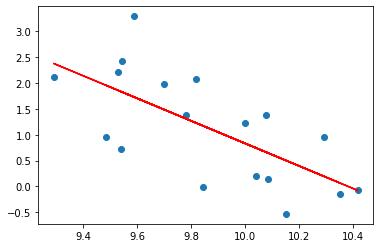

[[-2.17919023]]
-0.6758958735471616


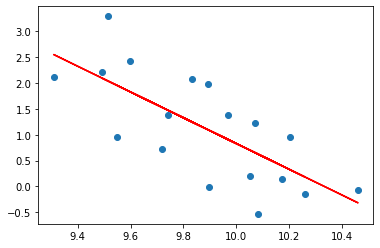

[[-2.49122836]]
-0.7232979727833192


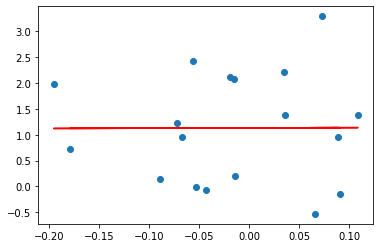

[[0.05388274]]
0.004437735350599559


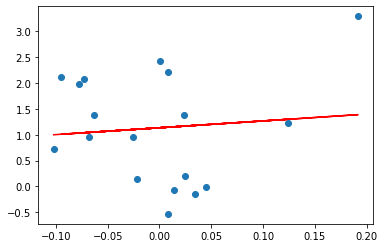

[[1.32217431]]
0.09379394262478606


In [ ]:
#correlazione alfa contra risposte corrette e sbagliate con d'
contra_match = match
contra_no = nomatch
contra_match = contra_match.groupby('subject').mean()['IAF_CONTRA']
print(contra_match)
contra_no = contra_no.groupby('subject').mean()['IAF_CONTRA']
contra_diff = (contra_match.sub(contra_no)) #abs

#grafici d' rispetto ad alfa ipsi e contra
X = contra_match.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])

X = contra_no.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])

#grafico d' rispetto alla differenza di alfa controlaterale match - nomatch
X = contra_diff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])


#grafico d' rispetto alla differenza di alfa ipsilaterale match - nomatch
dfsubIAF = df
dfsubIAF['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))

ipsi_match = match
ipsi_no = nomatch
ipsi_match = ipsi_match.groupby('subject').mean()['IAF_IPSI']
ipsi_no = ipsi_no.groupby('subject').mean()['IAF_IPSI']
ipsi_diff = (ipsi_match.sub(ipsi_no))

X = ipsi_diff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])


          subject  trial  stimulus  resp  outcome  IAF_CONTRA  IAF_IPSI  side  \
dominant                                                                        
0            2887   2887      2887  2887     2887        2887      2887  2887   
1            5779   5779      5779  5779     5779        5779      5779  5779   

          CONTRA-IPSI  
dominant               
0                2887  
1                5779  
0       10.508925
1       10.252848
2       10.142288
3        9.990184
4       10.662737
          ...    
8661     9.792463
8662    10.000206
8663    11.002576
8664     9.583649
8665    10.167344
Name: NONdominantIAF, Length: 8666, dtype: float64
0       10.767579
1       10.325212
2       10.336469
3       10.134740
4       10.326611
          ...    
8661     8.902465
8662     9.743543
8663     9.784555
8664     9.850196
8665    10.581633
Name: dominantIAF, Length: 8666, dtype: float64
subject
1      9.823389
2     10.342627
3      9.623107
4     10.076622
5      9.500

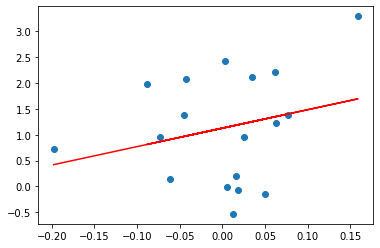

[[-2.59920102]]
-0.17795866703763266


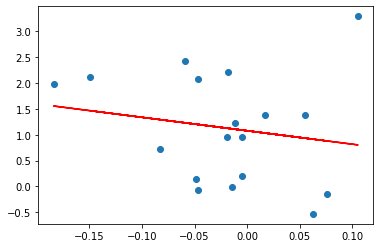

In [ ]:
from pandas.core.groupby import groupby
#d' with alfa contra and ipsi (biased)
#correlazione alfa contra risposte corrette e sbagliate con d'


df['dominant'] = 0 
df.loc[(df['side'] ==1 ) & ((df['stimulus']== 1)| (df['stimulus']== 3)), 'dominant'] = 1
df.loc[(df['side'] ==2 ) & ((df['stimulus']== 2)| (df['stimulus']== 4)), 'dominant'] = 1

aaa = df.groupby('dominant').count()
print(aaa)
df.loc[df['dominant'] == 1, 'dominantIAF'] = df['IAF_CONTRA']
df.loc[df['dominant'] == 0, 'dominantIAF'] = df['IAF_IPSI']
df.loc[df['dominant'] == 0, 'NONdominantIAF'] = df['IAF_CONTRA']
df.loc[df['dominant'] == 1, 'NONdominantIAF'] = df['IAF_IPSI']
print(df['NONdominantIAF'])
print(df['dominantIAF'])
df['Diff_IAF_DOM_NODOM'] = df['dominantIAF'].sub(df['NONdominantIAF'])

outcome = df.groupby('subject').mean('CONTRA-IPSI').reset_index()
outcome['dprime'] = dPrime

match = df[df['outcome'] == 1]
nomatch = df[df['outcome'] == 0]

dom_match = match.groupby('subject').mean()['dominantIAF']
print(dom_match)
dom_nomatch = nomatch.groupby('subject').mean()['dominantIAF']
dom_diff = (dom_match.sub(dom_nomatch)) #abs

nodom_match = match.groupby('subject').mean()['NONdominantIAF']
print(nodom_match)
nodom_nomatch = nomatch.groupby('subject').mean()['NONdominantIAF']
nodom_diff = (nodom_match.sub(nodom_nomatch)) #abs


X = dom_diff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = nodom_diff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()



           0
0   1.385470
1  -0.139617
2   2.427365
3   0.153145
4   0.954798
5   1.978922
6   2.213916
7   3.292110
8   0.206881
9  -0.059223
10  2.080963
11 -0.008016
12  0.964435
13  2.107787
14  1.385020
15  1.229561
16 -0.530645
17  0.725976
    subject   outcome
0         1  0.806250
1         2  0.764583
2         3  0.908333
3         4  0.662500
4         5  0.629191
5         6  0.780793
6         7  0.725000
7         8  0.879167
8         9  0.531250
9        10  0.562500
10       11  0.670833
11       12  0.647917
12       13  0.825000
13       14  0.812500
14       15  0.631250
15       16  0.829167
16       17  0.825000
17       18  0.908333


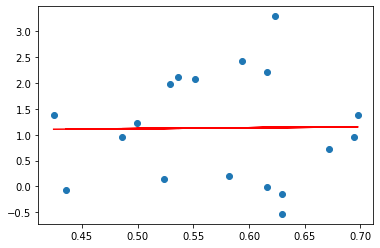

[[0.16465905]]
0.012593480766269233


In [ ]:
#mean difference contra-ipsi and d' or outcome. Next block std dev
dfsubIAF = df
dfsubIAF['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
#print(meandiff.reset_index())
print(dPrime)
stddiff = dfsubIAF.groupby('subject').std()['CONTRA-IPSI'] #mean or std
meandiff = dfsubIAF.groupby('subject').mean()['CONTRA-IPSI'] #mean or std
outcome = dfsubIAF.groupby('subject').mean()['outcome'].reset_index()
print(outcome)

#stddiff_do = stddiff.drop([3,13,15]) #neutral cue has subjects 3,13,15 with d'<0
#meandiff_do = meandiff.drop([3,13,15]) #neutral cue has subjects 3,13,15 with d'<0
#dPrime_do = dPrime.drop([3,13,15]) #neutral cue has subjects 3,13,15 with d'<0

meandiff_do = meandiff.drop([1,9,11,16])
stddiff_do = stddiff.drop([1,9,11,16])
dPrime_do = dPrime.drop([1,9,11,16])

#Y could be outcome_do or meandiff_do or stddiff_do
X = meandiff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])


subject
1     0.354745
2     0.499976
3     0.441573
4     0.429435
5     0.393839
6     0.435508
7     0.489326
8     0.487549
9     0.475482
10    0.369141
11    0.455259
12    0.475078
13    0.568398
14    0.438473
15    0.534552
16    0.470270
17    0.527931
18    0.495601
Name: CONTRA-IPSI, dtype: float64
subject
1     0.354745
2     0.499976
3     0.441573
4     0.429435
5     0.393839
6     0.435508
7     0.489326
8     0.487549
9     0.475482
10    0.369141
11    0.455259
12    0.475078
13    0.568398
14    0.438473
15    0.534552
16    0.470270
17    0.527931
18    0.495601
Name: CONTRA-IPSI, dtype: float64


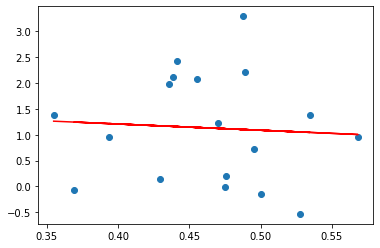

[[-1.2056882]]
-0.06298515606795771


In [ ]:
#std dev of difference contra-ipsi and d'
dfsubIAF = df
dfsubIAF['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))


stddiff = dfsubIAF.groupby('subject').std()['CONTRA-IPSI']
print(stddiff)
meandiff = dfsubIAF.groupby('subject').mean()['CONTRA-IPSI']
#stddiff_do = stddiff.drop([3,13,15])
#dPrime_do = dPrime.drop([3,13,15])
stddiff_do = stddiff.drop([1,9,11,16])
dPrime_do = dPrime.drop([1,9,11,16])
print(stddiff)
X = stddiff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dPrime.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])




In [ ]:

#sub = df['subject'].unique()
#sub['avg'] = sum(df[df['outcome']
outcome = df.groupby('subject').mean('outcome').reset_index()
outcome['dprime'] = dPrime
outcome


subject  trial  stimulus      resp   outcome  IAF_CONTRA   IAF_IPSI  side  \
0         1  240.5  2.333333  0.422917  0.806250    9.771285   9.780754   1.0   
1         2  240.5  2.333333  0.643750  0.764583   10.330696  10.370221   1.0   
2         3  240.5  2.333333  0.433333  0.908333    9.547809   9.509380   1.0   
3         4  240.5  2.333333  0.570833  0.662500   10.112566  10.058751   1.0   
4         5  254.0  2.329389  0.325444  0.629191    9.508144   9.489045   1.0   
5         6  240.0  2.329854  0.329854  0.780793    9.740324   9.727437   1.0   
6         7  240.5  2.333333  0.254167  0.725000    9.517361   9.536131   1.0   
7         8  240.5  2.333333  0.379167  0.879167    9.579504   9.543110   1.0   
8         9  240.5  2.666667  0.452083  0.531250   10.045166  10.016408   2.0   
9        10  240.5  2.666667  0.575000  0.562500   10.436303  10.427601   2.0   
10       11  240.5  2.666667  0.204167  0.670833    9.822104   9.789223   2.0   
11       12  240.5  2.666667  0.606250  0.647917    9.862985   9.889868   2.0   
12       13  240.5  2.666667  0.495833  0.825000   10.277782  10.403831   2.0   
13       14  240.5  2.666667  0.354167  0.812500    9.293275   9.192911   2.0   
14       15  240.5  2.666667  0.239583  0.631250   10.037742  10.060150   2.0   
15       16  240.5  2.666667  0.462500  0.829167   10.009919  10.052485   2.0   
16       17  240.5  2.666667  0.650000  0.825000   10.138226  10.090710   2.0   
17       18  240.5  2.333333  0.541667  0.908333    9.556952   9.558376   1.0   

    CONTRA-IPSI  dominant  dominantIAF  NONdominantIAF  Diff_IAF_DOM_NODOM  \
0      0.424781  0.666667     9.832093        9.719946            0.112148   
1      0.629388  0.666667    10.331001       10.369916           -0.038915   
2      0.593777  0.666667     9.622810        9.434378            0.188432   
3      0.523357  0.666667    10.097497       10.073820            0.023677   
4      0.486211  0.668639     9.527921        9.469268            0.058652   
5      0.529570  0.668058     9.694591        9.773170           -0.078579   
6      0.616086  0.666667     9.509729        9.543763           -0.034034   
7      0.623643  0.666667     9.621746        9.500867            0.120879   
8      0.582435  0.666667     9.998137       10.063437           -0.065299   
9      0.435712  0.666667    10.428676       10.435229           -0.006553   
10     0.551244  0.666667     9.850153        9.761174            0.088980   
11     0.616451  0.666667     9.831522        9.921330           -0.089807   
12     0.694263  0.666667    10.206424       10.475189           -0.268765   
13     0.536164  0.666667     9.290342        9.195844            0.094498   
14     0.697799  0.666667    10.063012       10.034879            0.028133   
15     0.499162  0.666667     9.954274       10.108129           -0.153855   
16     0.630022  0.666667    10.098369       10.130567           -0.032198   
17     0.671852  0.666667     9.553572        9.561757           -0.008185   

      dprime  
0   1.385470  
1  -0.139617  
2   2.427365  
3   0.153145  
4   0.954798  
5   1.978922  
6   2.213916  
7   3.292110  
8   0.206881  
9  -0.059223  
10  2.080963  
11 -0.008016  
12  0.964435  
13  2.107787  
14  1.385020  
15  1.229561  
16 -0.530645  
17  0.725976

In [ ]:
import statistics

median = statistics.median(outcome['dprime'])
print(median)

lowperf = outcome[outcome['dprime'] < median]
highperf = outcome[outcome['dprime'] >= median]

print(lowperf)
print(highperf)
#tp = [1,3,6,7,8,11,14,15,16] #top performers d' (biased)
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)



1.0969976154059395
    subject  trial  stimulus      resp   outcome  IAF_CONTRA   IAF_IPSI  side  \
1         2  240.5  2.333333  0.643750  0.764583   10.330696  10.370221   1.0   
3         4  240.5  2.333333  0.570833  0.662500   10.112566  10.058751   1.0   
4         5  254.0  2.329389  0.325444  0.629191    9.508144   9.489045   1.0   
8         9  240.5  2.666667  0.452083  0.531250   10.045166  10.016408   2.0   
9        10  240.5  2.666667  0.575000  0.562500   10.436303  10.427601   2.0   
11       12  240.5  2.666667  0.606250  0.647917    9.862985   9.889868   2.0   
12       13  240.5  2.666667  0.495833  0.825000   10.277782  10.403831   2.0   
16       17  240.5  2.666667  0.650000  0.825000   10.138226  10.090710   2.0   
17       18  240.5  2.333333  0.541667  0.908333    9.556952   9.558376   1.0   

    CONTRA-IPSI  dominant  dominantIAF  NONdominantIAF  Diff_IAF_DOM_NODOM  \
1      0.629388  0.666667    10.331001       10.369916           -0.038915   
3      0.52335

9.675304572043947
0.7672089902720273
9.660394421302474
0.7974342855693912
10.05573968255
0.7992968238969307
10.06043299426503
0.7873976233233203
9.67634932510667
0.2353126374307757
9.661465354871083
0.26760584140193316
10.055666669617125
0.27188799630603566
10.060355911974003
0.28744089537602047
0.0149101507414724
0.7235347258813143
-0.004693311715027607
0.7634086725904857
0.014883970235586907
0.04093681542775545
-0.004689242356879035
0.051854836590299186


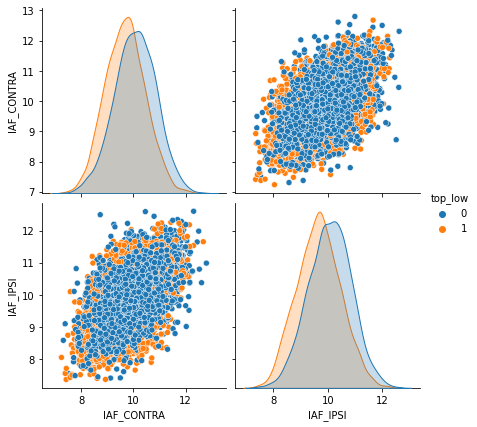

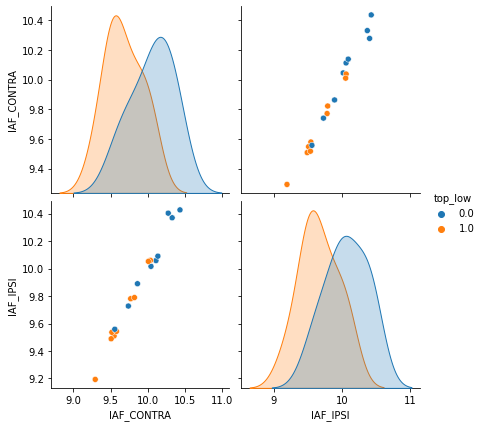

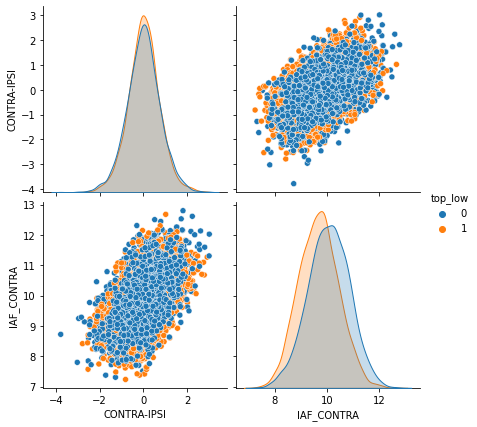

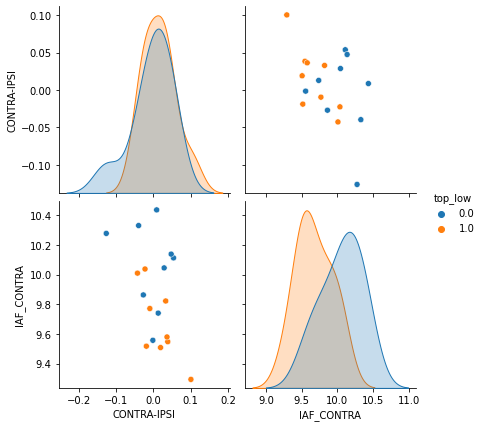

In [ ]:
#tp = [1,2,3,4,5,6,12,17,19] #top performers outcome (neutral)
#tp = [1,2,5,6,7,8,10,11,16,18] #top performers d' (neutral2) no
#tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

df['top_low'] = 0
df.loc[df.subject.isin(tp), 'top_low'] = 1
df['CONTRA-IPSI'] = df['IAF_CONTRA'].sub(df['IAF_IPSI'])
sns.pairplot(df, hue='top_low', height=3, vars=['IAF_CONTRA', 'IAF_IPSI']);
toplow = df.groupby('subject').mean('outcome').reset_index()
sns.pairplot(toplow, hue='top_low', height=3, vars=['IAF_CONTRA', 'IAF_IPSI']);

sns.pairplot(df, hue='top_low', height=3, vars=['CONTRA-IPSI', 'IAF_CONTRA']);
#df.plot.hist(by=['top_low', 'CONTRA_IPSI'], bins=5)

sns.pairplot(toplow, hue='top_low', height=3, vars=['CONTRA-IPSI', 'IAF_CONTRA']);
#outcome.plot.hist(by='top_low', bins=5)
topp = df[df['top_low'] == 1]
lowp = df[df['top_low'] == 0]

outcome = df.groupby('subject').mean('outcome').reset_index()
topp_mean = outcome[outcome['top_low'] == 1]
lowp_mean = outcome[outcome['top_low'] == 0]

print(np.mean(topp['IAF_CONTRA']))
print(np.std(topp['IAF_CONTRA']))
print(np.mean(topp['IAF_IPSI']))
print(np.std(topp['IAF_IPSI']))

print(np.mean(lowp['IAF_CONTRA']))
print(np.std(lowp['IAF_CONTRA']))
print(np.mean(lowp['IAF_IPSI']))
print(np.std(lowp['IAF_IPSI']))


print(np.mean(topp_mean['IAF_CONTRA']))
print(np.std(topp_mean['IAF_CONTRA']))
print(np.mean(topp_mean['IAF_IPSI']))
print(np.std(topp_mean['IAF_IPSI']))

print(np.mean(lowp_mean['IAF_CONTRA']))
print(np.std(lowp_mean['IAF_CONTRA']))
print(np.mean(lowp_mean['IAF_IPSI']))
print(np.std(lowp_mean['IAF_IPSI']))



print(np.mean(topp['CONTRA-IPSI']))
print(np.std(topp['CONTRA-IPSI']))


print(np.mean(lowp['CONTRA-IPSI']))
print(np.std(lowp['CONTRA-IPSI']))

print(np.mean(topp_mean['CONTRA-IPSI']))
print(np.std(topp_mean['CONTRA-IPSI']))


print(np.mean(lowp_mean['CONTRA-IPSI']))
print(np.std(lowp_mean['CONTRA-IPSI']))



In [ ]:
#response and confidence time in top and low perf
#tp = [1,2,3,4,5,6,12,17,19] #top performers outcome (neutral)
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral1)
#tp = [0,2,5,6,7,10,13,14,15] #top performers d' (biased2)



time = match
print(time)

time['top_low'] = 0
time.loc[time.subject.isin(tp), 'top_low'] = 1

time = time.drop(time[time.resp_time<=0].index)
time = time.drop(time[time.conf_time<=0].index)


meantime = match.groupby('subject').mean('outcome').reset_index()
#meantime = time.groupby('subject').mean('outcome').reset_index()


sns.pairplot(time, hue='top_low', height=3, vars=['resp_time', 'conf_time']);
sns.pairplot(meantime, hue='top_low', height=3, vars=['resp_time', 'conf_time']);
#sns.pairplot(matchresptime, hue='top_low', height=3, vars=['IAF_CONTRA', 'IAF_IPSI']);

#topt = meantime[meantime['top_low'] == 1]
#lowt = meantime[meantime['top_low'] == 0]

topt = meantime[meantime['top_low'] == 1]
lowt = meantime[meantime['top_low'] == 0]

print(np.mean(topt['resp_time']))
print(np.std(topt['resp_time']))
print(np.mean(topt['conf_time']))
print(np.std(topt['conf_time']))

print(np.mean(lowt['resp_time']))
print(np.std(lowt['resp_time']))
print(np.mean(lowt['conf_time']))
print(np.std(lowt['conf_time']))



      subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
0           1      1         1     0        1   10.767579  10.508925     1   
1           1      2         2     0        1   10.252848  10.325212     1   
3           1      4         1     0        1   10.134740   9.990184     1   
4           1      5         3     1        1   10.326611  10.662737     1   
5           1      6         3     1        1   10.497952  10.179877     1   
...       ...    ...       ...   ...      ...         ...        ...   ...   
8661       18    476         1     0        1    8.902465   9.792463     1   
8662       18    477         1     0        1    9.743543  10.000206     1   
8663       18    478         1     0        1    9.784555  11.002576     1   
8664       18    479         3     1        1    9.850196   9.583649     1   
8665       18    480         3     1        1   10.581633  10.167344     1   

      CONTRA-IPSI  dominant  dominantIAF  NONdominantIAF  Diff_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


AttributeError: ignored

In [ ]:
tp = [1,2,3,4,5,6,12,17,19] #top performers

df['top_low'] = 0
df.loc[df.subject.isin(tp), 'top_low'] = 1

toplowexperiment = df.groupby('top_low').mean('outcome').reset_index()
toplowexperiment

In [ ]:
sns.pairplot(outcome, hue='subject', height=3, vars=['resp','outcome', 'confidence', 'IAF_IPSI', 'IAF_CONTRA', 'resp_time', 'conf_time']);

In [ ]:
#relazione tra media alfa ipsi e media outcome
outcome = df.groupby('subject').mean('IAF_IPSI').reset_index()
outcome['dprime'] = dPrime

diff = abs(outcome['IAF_CONTRA'].sub(outcome['IAF_IPSI']))
Y = outcome['dprime'].values.reshape(-1, 1)  # values converts it into a numpy array
X = outcome['IAF_IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])

#relazione tra media alfa contra e media outcome

Y = outcome['dprime'].values.reshape(-1, 1)  # values converts it into a numpy array
X = outcome['IAF_CONTRA'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])



In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

X = outcome['IAF_CONTRA']  # values converts it into a numpy array
Y = outcome['dprime']  # -1 means that calculate the dimension of rows, but have 1 column
Z = outcome[['dprime', 'IAF_CONTRA']] #list(zip(X,Y))
Z = normalize(Z)

linked = linkage(Z, method='ward')
labelList = range(1, 19)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = KMeans(n_clusters=2)#, affinity='euclidean', linkage='ward')
cluster.fit_predict(Z)
plt.scatter(X, Y, c=cluster.labels_, cmap='rainbow')

In [ ]:
#d' with alfa contra and ipsi (only for neutral condition)
outcome['dprime'] = dPrime
print(outcome)

X = outcome['IAF_CONTRA'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['IAF_IPSI'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
aa

          subject  trial  stimulus  resp  outcome  IAF_CONTRA  IAF_IPSI  side  \
dominant                                                                        
0            2887   2887      2887  2887     2887        2887      2887  2887   
1            5779   5779      5779  5779     5779        5779      5779  5779   

          CONTRA-IPSI  dominantIAF  NONdominantIAF  Diff_IAF_DOM_NODOM  
dominant                                                                
0                2887         2887            2887                2887  
1                5779         5779            5779                5779  
0       10.508925
1       10.252848
2       10.142288
3        9.990184
4       10.662737
          ...    
8661     9.792463
8662    10.000206
8663    11.002576
8664     9.583649
8665    10.167344
Name: NONdominantIAF, Length: 8666, dtype: float64
0       10.767579
1       10.325212
2       10.336469
3       10.134740
4       10.326611
          ...    
8661     8.902465
8662    

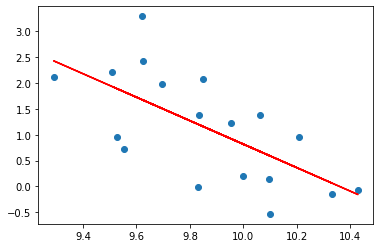

[[-1.95988855]]
-0.6835269951651295


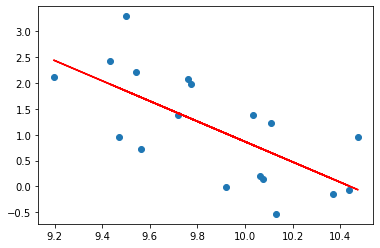

[[4.38523446]]
0.44832532618347065


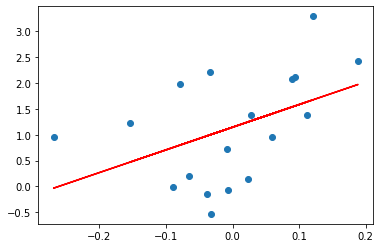

In [ ]:
from pandas.core.groupby import groupby
#d' with alfa contra and ipsi (biased)
outcome['dprime'] = dPrime
df['dominant'] = 0 
df.loc[(df['side'] ==1 ) & ((df['stimulus']== 1)| (df['stimulus']== 3)), 'dominant'] = 1
df.loc[(df['side'] ==2 ) & ((df['stimulus']== 2)| (df['stimulus']== 4)), 'dominant'] = 1

aaa = df.groupby('dominant').count()
print(aaa)
df.loc[df['dominant'] == 1, 'dominantIAF'] = df['IAF_CONTRA']
df.loc[df['dominant'] == 0, 'dominantIAF'] = df['IAF_IPSI']
df.loc[df['dominant'] == 0, 'NONdominantIAF'] = df['IAF_CONTRA']
df.loc[df['dominant'] == 1, 'NONdominantIAF'] = df['IAF_IPSI']
print(df['NONdominantIAF'])
print(df['dominantIAF'])
df['Diff_IAF_DOM_NODOM'] = df['dominantIAF'].sub(df['NONdominantIAF'])

outcome = df.groupby('subject').mean('CONTRA-IPSI').reset_index()
outcome['dprime'] = dPrime
X = outcome['dominantIAF'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['NONdominantIAF'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['Diff_IAF_DOM_NODOM'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

subject
2     1
3     2
4     1
6     1
7     1
9     2
10    2
12    6
13    3
16    3
17    5
18    3
Name: outcome, dtype: int64
subject
1     1
2     3
4     3
5     1
7     1
9     3
10    9
12    5
13    3
15    2
16    2
17    6
18    6
Name: outcome, dtype: int64
subject
1     1
2     6
4     3
6     1
7     2
9     2
10    5
12    5
13    1
16    1
17    6
18    6
Name: outcome, dtype: int64
subject
4     10
5      1
9      5
10     7
12     4
13     2
16     5
17     5
18     4
Name: outcome, dtype: int64
subject
1     1
2     5
3     2
4     9
7     1
9     6
10    1
12    5
13    4
14    1
15    3
17    3
18    3
Name: outcome, dtype: int64
subject
1     2
2     4
3     1
4     4
5     1
9     5
10    8
11    1
12    5
13    3
14    3
17    6
18    2
Name: outcome, dtype: int64
subject
1      2
2      3
4      2
5      3
9      4
10    10
11     1
12     6
13     2
15     1
16     1
17     3
18     1
Name: outcome, dtype: int64
subject
1      2
2      5
4     10
5      4
6 

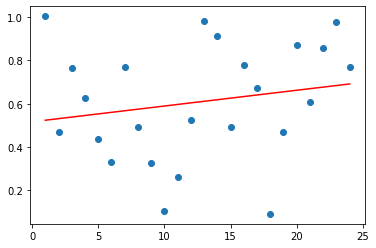

[[0.01092297]]
0.2533529600108023


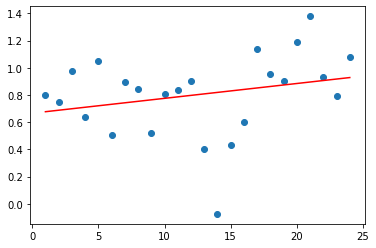

In [ ]:
#d' w/r to time in top and low performers
bins = []
for i in range(1,25):
  bins.append(df[(df['trial'] >= i+(i-1)*19) & (df['trial'] <= i+i*19)])
#print(bins)

dp = []
data = pd.DataFrame()
for i in range(0,24):
  #dp.append(dPrimef(bins[i]))
  dp = pd.DataFrame(dPrimef(bins[i]))
  data = pd.concat([data,dp],axis=1,join='outer')
#print(dp)
#print(data)
#print(data.mean())
#tp = [1,2,5,6,7,8,10,11,16,18] #top performers d' (neutral2) no
#tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

topd = data[data.index.isin(tp)]
lowd = data[~data.index.isin(tp)]
primes = data.mean()
topprimes = topd.mean()
lowprimes = lowd.mean()
#print(primes)
nums = pd.DataFrame(range(1,25))

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = topprimes.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = lowprimes.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()


In [ ]:
#alpha difference w/r to time in top and low performers


tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral2)
#tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)
df['CONTRA-IPSI'] = df['IAF_CONTRA'].sub(df['IAF_IPSI'])

binsT = []
binsL = []
top = df[df['subject'].isin(tp)]
low = df[~df['subject'].isin(tp)]
print(top)
print(low)

for i in range(1,25):
  binsT.append(top[(top['trial'] >= i+(i-1)*19) & (top['trial'] <= i+i*19)])
  binsL.append(low[(low['trial'] >= i+(i-1)*19) & (low['trial'] <= i+i*19)])

diffT = []
diffL = []

dataT = []#pd.DataFrame()
dataL = []#pd.DataFrame()

for i in range(0,24):
  #dp.append(dPrimef(bins[i]))
  diffT = abs(binsT[i].mean()['CONTRA-IPSI']) #['CONTRA-IPSI']
  diffL = abs(binsL[i].mean()['CONTRA-IPSI'])

  dataT.append(diffT)# = pd.concat([dataT,dp],axis=1,join='outer')
  dataL.append(diffL)# = pd.concat([dataL,dp],axis=1,join='outer')

dataT = pd.DataFrame(dataT)
dataL = pd.DataFrame(dataL)

print(dataT)
print(dataL)

#top24 = topd.mean()
#low24 = lowd.mean()
#print(primes)
nums = pd.DataFrame(range(1,25))

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dataT.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dataL.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()


KeyError: ignored

In [ ]:
#d' and trials (divide in 5 groups) MEAN
outcome = df.groupby('subject').mean('CONTRA-IPSI').reset_index()
outcome['dprime'] = dPrime
"""bins = []
for i in range(1,24):
  bins.append(dPrimef(df[(df['trial'] >= i+(i-1)*19) & (df['trial'] <= i+i*19)]))
print(bins)  
"""
trials1 = df[(df['trial'] >= 1) & (df['trial'] < 97)]
trials2 = df[(df['trial'] >= 97) & (df['trial'] < 193)]
trials3 = df[(df['trial'] >= 193) & (df['trial'] < 289)]
trials4 = df[(df['trial'] >= 289) & (df['trial'] < 385)]
trials5 = df[(df['trial'] >= 385) & (df['trial'] <= 480)]
divtrial1 = dPrimef(trials1)
divtrial2 = dPrimef(trials2)
divtrial3 = dPrimef(trials3)
divtrial4 = dPrimef(trials4)
divtrial5 = dPrimef(trials5)
outcome['1']= divtrial1
outcome['2']= divtrial2
outcome['3']= divtrial3
outcome['4']= divtrial4
outcome['5']= divtrial5
print(outcome)
outcome = outcome.dropna()
block = outcome.transpose()
block = block.loc[['1','2','3','4','5']]
print(block)

block_avg = block.transpose()
block_avg.index = block_avg.index.set_names(['subject'])
avg = pd.DataFrame(block_avg.mean())
print(block_avg)
print(avg)
avg['block'] = [1,2,3,4,5]
avg['dprime'] = [0.883191, 0.519330, 0.923818, 0.995244, 1.351281] #neutral[0.605350, 0.774627, 0.700761, 0.989555, 0.902977] #[ 0.444116, 0.609572, 0.554381, 0.864007, 0.764098]  
#print(trials3)

X = avg['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = avg['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])

plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()
#
"""

#d' and trials (divide in 5 groups) EVERY BLOCK
block['block'] = [1,2,3,4,5]

print(block)

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,0].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X =block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,2].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,4].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,5].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,6].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,7].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,8].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = block['block'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = block.iloc[:,9].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
#dprime nei vari blocchi (ogni punto è un soggetto)

X = outcome['3'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['3'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['4'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = outcome['5'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = outcome['dprime'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()"""

In [ ]:
#differenze tra corretto ed errore si modificano con il passare di trial, 
#tipo fare i 24 bins di 20 trial e guardare come la differenza si modula,
#anche in funzione di performance generale (quelli piu bravi dovrebbero modularlo di piu). 
outcome['dprime'] = dPrime
#print(outcome)

#tp = [1,2,5,6,7,8,10,11,16,18] #top performers d' (neutral2) no
#tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

top = df[df.index.isin(tp)]     #è già un groupby!
low = df[~df.index.isin(tp)]

pos = top[top['outcome'] == 1]
neg = top[top['outcome'] == 0]

pos2 = low[low['outcome'] == 1]
neg2 = low[low['outcome'] == 0]
#pos = pos.groupby('subject').mean()['IAF_CONTRA']
#neg = neg.groupby('subject').mean()['IAF_CONTRA']
#contra_diff = abs(pos.sub(neg))

tp = []
tn = []
lp = []
ln = []
dataT = []
dataL = []


binsp = []
binsn = []

binsp2 = []
binsn2 = []

for i in range(1,25):
  binsp.append(pos[(pos['trial'] >= i+(i-1)*19) & (pos['trial'] <= i+i*19)]['IAF_CONTRA'])
  binsn.append(neg[(neg['trial'] >= i+(i-1)*19) & (neg['trial'] <= i+i*19)]['IAF_CONTRA'])

for i in range(1,25):
  binsp2.append(pos2[(pos2['trial'] >= i+(i-1)*19) & (pos2['trial'] <= i+i*19)]['IAF_CONTRA'])
  binsn2.append(neg2[(neg2['trial'] >= i+(i-1)*19) & (neg2['trial'] <= i+i*19)]['IAF_CONTRA'])
print(binsp)
print(binsn)

#binsp = pd.DataFrame(binsp)
#binsn = pd.DataFrame(binsn)
#binsp2 = pd.DataFrame(binsp2)
#binsn2 = pd.DataFrame(binsn2)

#subT = binsp.mean().sub(binsn.mean())

for i in range(0,24):
  #dp.append(dPrimef(bins[i]))
  tp.append(np.mean(binsp[i]))
  tn.append(np.mean(binsn[i]))
  dataT.append(tp[i]-tn[i])
subT = pd.DataFrame(dataT)
#subT = subT.loc[1:24]"""
print(subT)

for i in range(0,24):
  #dp.append(dPrimef(bins[i]))
  lp.append(np.mean(binsp2[i]))
  ln.append(np.mean(binsp2[i]))
  dataL.append(lp[i]-ln[i])
subL = pd.DataFrame(dataL)
#subL = subL.loc[1:24]
print(subL)

nums = pd.DataFrame(range(0,24))

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = subT.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

X = nums.values.reshape(-1, 1)  # values converts it into a numpy array
Y = subL.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()
"""
c = df.groupby('subject').mean('outcome')
c['contra_diff1'] = contra_diff
c['divph1'] = divph1.shift()
c = c[['contra_diff1', 'divph1']]
c = c.dropna()

#print(bins)

#print(data)
#print(data.mean())
#tp = [1,2,5,6,7,8,10,11,16,18] #top performers d' (neutral2) no
#tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

topd = data[data.index.isin(tp)]
lowd = data[~data.index.isin(tp)]
primes = data.mean()
topprimes = topd.mean()
lowprimes = lowd.mean()
#print(primes)
nums = pd.DataFrame(range(1,25))


"""

In [ ]:
#differenze tra corretto ed errore si modificano con il passare di trial, 
#tipo fare i 5 bins di 96 trial e guardare come la differenza si modula,
#anche in funzione di performance generale (quelli piu bravi dovrebbero modularlo di piu). 
outcome['dprime'] = dPrime
#print(outcome)
contra_match = match
contra_no = nomatch
contra_match = contra_match.groupby('subject').mean()['IAF_CONTRA']
contra_no = contra_no.groupby('subject').mean()['IAF_CONTRA']
contra_diff = abs(contra_match.sub(contra_no))

ipsi_match = match
ipsi_no = nomatch
ipsi_match = ipsi_match.groupby('subject').mean()['IAF_IPSI']
ipsi_no = ipsi_no.groupby('subject').mean()['IAF_IPSI']
ipsi_diff = abs(ipsi_match.sub(ipsi_no))

ph1p = ph1[ph1['outcome'] == 1]
ph1m = ph1[ph1['outcome'] == 0]

ph1p = ph1p.groupby('subject').mean()['IAF_CONTRA']
ph1m = ph1m.groupby('subject').mean()['IAF_CONTRA']
contra_diff1 = abs(ph1p.sub(ph1m))

divph1 = dPrimef(ph1)

c1 = df.groupby('subject').mean('outcome')
c1['contra_diff1'] = contra_diff1
c1['divph1'] = divph1.shift()
c1 = c1[['contra_diff1', 'divph1']]
c1 = c1.dropna()
#print(contra_diff)
"""
ph1 = df[(df['trial'] >= 1) & (df['trial'] < 97)]
ph2 = df[(df['trial'] >= 97) & (df['trial'] < 193)]
ph3 = df[(df['trial'] >= 193) & (df['trial'] < 289)]
ph4 = df[(df['trial'] >= 289) & (df['trial'] < 385)]
ph5 = df[(df['trial'] >= 385) & (df['trial'] <= 480)]
ph1p = ph1[ph1['outcome'] == 1]
ph1m = ph1[ph1['outcome'] == 0]
ph2p = ph2[ph2['outcome'] == 1]
ph2m = ph2[ph2['outcome'] == 0]
ph3p = ph3[ph3['outcome'] == 1]
ph3m = ph3[ph3['outcome'] == 0]
ph4p = ph4[ph4['outcome'] == 1]
ph4m = ph4[ph4['outcome'] == 0]
ph5p = ph5[ph5['outcome'] == 1]
ph5m = ph5[ph5['outcome'] == 0]
ph1p = ph1p.groupby('subject').mean()['IAF_CONTRA']
ph1m = ph1m.groupby('subject').mean()['IAF_CONTRA']
contra_diff1 = abs(ph1p.sub(ph1m))
ph2p = ph2p.groupby('subject').mean()['IAF_CONTRA']
ph2m = ph2m.groupby('subject').mean()['IAF_CONTRA']
contra_diff2 = abs(ph2p.sub(ph2m))
ph3p = ph3p.groupby('subject').mean()['IAF_CONTRA']
ph3m = ph3m.groupby('subject').mean()['IAF_CONTRA']
contra_diff3 = abs(ph3p.sub(ph3m))
ph4p = ph4p.groupby('subject').mean()['IAF_CONTRA']
ph4m = ph4m.groupby('subject').mean()['IAF_CONTRA']
contra_diff4 = abs(ph4p.sub(ph4m))
ph5p = ph5p.groupby('subject').mean()['IAF_CONTRA']
ph5m = ph5m.groupby('subject').mean()['IAF_CONTRA']
contra_diff5 = abs(ph5p.sub(ph5m))

divph1 = dPrimef(ph1)
divph2 = dPrimef(ph2)
divph3 = dPrimef(ph3)
divph4 = dPrimef(ph4)
divph5 = dPrimef(ph5)

c1 = df.groupby('subject').mean('outcome')
c1['contra_diff1'] = contra_diff1
c1['divph1'] = divph1.shift()
c1 = c1[['contra_diff1', 'divph1']]
c1 = c1.dropna()
#print(c1)

c2 = df.groupby('subject').mean('outcome')
c2['contra_diff2'] = contra_diff2
c2['divph2'] = divph2.shift()
c2 = c2[['contra_diff2', 'divph2']]
c2 = c2.dropna()
#print(c2)

c3 = df.groupby('subject').mean('outcome')
c3['contra_diff3'] = contra_diff3
c3['divph3'] = divph3.shift()
c3 = c3[['contra_diff3', 'divph3']]
c3 = c3.dropna()
#print(contra_diff3)
#print(divph3)
#print(c3)

c4 = df.groupby('subject').mean('outcome')
c4['contra_diff4'] = contra_diff4
c4['divph4'] = divph4.shift()
c4 = c4[['contra_diff4', 'divph4']]
c4 = c4.dropna()

c5 = df.groupby('subject').mean('outcome')
c5['contra_diff5'] = contra_diff5
c5['divph5'] = divph5.shift()
c5 = c5[['contra_diff5', 'divph5']]
c5 = c5.dropna()
print(contra_diff5)
print(divph5)
print(c5)


outcome['1']= divph1
outcome['2']= divph2
outcome['3']= divph3
outcome['4']= divph4
outcome['5']= divph5
#print(outcome)
outcome = outcome.dropna()
#block = outcome.transpose()
#block = block.loc[['1','2','3','4','5']]
#print(block)

#block_avg = block.transpose()
#block_avg.index = block_avg.index.set_names(['subject'])
#avg = pd.DataFrame(block_avg.mean())
#avg['block'] = [1,2,3,4,5]
#avg['dprime'] = [ 0.444116, 0.609572, 0.554381, 0.864007, 0.764098]  



#grafico d' rispetto alla differenza di alfa controlaterale match - nomatch
X = c1['contra_diff1'].values.reshape(-1, 1)  # values converts it into a numpy array
Y =c1['divph1'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)


X = c2['contra_diff2'].values.reshape(-1, 1)  # values converts it into a numpy array
Y =c2['divph2'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)

X = c3['contra_diff3'].values.reshape(-1, 1)  # values converts it into a numpy array
Y =c3['divph3'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)

X = c4['contra_diff4'].values.reshape(-1, 1)  # values converts it into a numpy array
Y =c4['divph4'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)

X = c5['contra_diff5'].values.reshape(-1, 1)  # values converts it into a numpy array
Y =c5['divph5'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)

#ipsi
dfsubIAF = df
dfsubIAF['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
"""

In [ ]:
#d' and average difference contra-ipsi (divide in 5 groups) MEAN
#it's a old copy

#tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)
outcome['dprime'] = dPrime
#print(outcome)
ph1 = df[(df['trial'] >= 1) & (df['trial'] < 97)]
ph2 = df[(df['trial'] >= 97) & (df['trial'] < 193)]
ph3 = df[(df['trial'] >= 193) & (df['trial'] < 289)]
ph4 = df[(df['trial'] >= 289) & (df['trial'] < 385)]
ph5 = df[(df['trial'] >= 385) & (df['trial'] <= 480)]
ph1p = ph1[ph1['outcome'] == 1]
ph1m = ph1[ph1['outcome'] == 0]
ph2p = ph2[ph2['outcome'] == 1]
ph2m = ph2[ph2['outcome'] == 0]
ph3p = ph3[ph3['outcome'] == 1]
ph3m = ph3[ph3['outcome'] == 0]
ph4p = ph4[ph4['outcome'] == 1]
ph4m = ph4[ph4['outcome'] == 0]
ph5p = ph5[ph5['outcome'] == 1]
ph5m = ph5[ph5['outcome'] == 0]

ph1p = ph1p.groupby('subject').mean()['IAF_CONTRA']
ph1m = ph1m.groupby('subject').mean()['IAF_CONTRA']
contra_diff1 = abs(ph1p.sub(ph1m))
ph2p = ph2p.groupby('subject').mean()['IAF_CONTRA']
ph2m = ph2m.groupby('subject').mean()['IAF_CONTRA']
contra_diff2 = abs(ph2p.sub(ph2m))
ph3p = ph3p.groupby('subject').mean()['IAF_CONTRA']
ph3m = ph3m.groupby('subject').mean()['IAF_CONTRA']
contra_diff3 = abs(ph3p.sub(ph3m))
ph4p = ph4p.groupby('subject').mean()['IAF_CONTRA']
ph4m = ph4m.groupby('subject').mean()['IAF_CONTRA']
contra_diff4 = abs(ph4p.sub(ph4m))
ph5p = ph5p.groupby('subject').mean()['IAF_CONTRA']
ph5m = ph5m.groupby('subject').mean()['IAF_CONTRA']
contra_diff5 = abs(ph5p.sub(ph5m))


diff_block = pd.DataFrame()
diff_block['1'] = contra_diff1
diff_block['2'] = contra_diff2
diff_block['3'] = contra_diff3
diff_block['4'] = contra_diff4
diff_block['5'] = contra_diff5
diff_block = diff_block
print(diff_block)
diff_t = diff_block.transpose()
print(diff_t)
diff_t['block'] = [1,2,3,4,5]

"""for i in range(1,20):

  X = diff_t['block'].values.reshape(-1, 1)  # values converts it into a numpy array
  Y = diff_t[{i}].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)
  print(linear_regressor.coef_)
  plt.scatter(X, Y)
  #df.reset_index().plot(kind='scatter', x='index', y='columnA')
  plt.plot(X, Y_pred, color='red')
  plt.show()"""

#tp = [1,2,3,4,5,6,12,17,19] #top performers outcome (neutral)
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
#tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

topd = diff_block[diff_block.index.isin(tp)]
lowd = diff_block[~diff_block.index.isin(tp)]
topd = pd.DataFrame(topd.mean(), columns=['d'])
topd['n']=[1,2,3,4,5]
lowd = pd.DataFrame(lowd.mean(), columns=['d'])
lowd['n']=[1,2,3,4,5]

print(topd)

X = topd['n'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = topd['d'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

X = lowd['n'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = lowd['d'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

"""divph1 = dPrimef(ph1)
divph2 = dPrimef(ph2)
divph3 = dPrimef(ph3)
divph4 = dPrimef(ph4)
divph5 = dPrimef(ph5)


dp1= divph1.dropna().mean()
d1 = contra_diff1.dropna().mean()
dp2 = divph2.dropna().mean()
d2 = contra_diff2.dropna().mean()
dp3 = divph3.dropna().mean()
d3 = contra_diff3.dropna().mean()
dp4 = divph4.dropna().mean()
d4 = contra_diff4.dropna().mean()
dp5= divph5.dropna().mean()
d5 = contra_diff5.dropna().mean()
dprime_blocks = pd.DataFrame([dp1, dp2, dp3, dp4, dp5])
IAF_diff = pd.DataFrame([d1, d2, d3, d4, d5])
print(dprime_blocks)
print(IAF_diff)
diff = pd.DataFrame(dprime_blocks, columns =['dprime'])#, IAF_diff])
diff['diff'] = IAF_diff
diff['dprime'] = dprime_blocks
diff['num'] = [1,2,3,4,5]
print(diff)

X = IAF_diff.values.reshape(-1, 1)  # values converts it into a numpy array
Y = dprime_blocks.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
#df.reset_index().plot(kind='scatter', x='index', y='columnA')
plt.plot(X, Y_pred, color='red')
plt.show()

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
threedee = plt.figure().gca(projection='3d')
threedee.plot(diff['diff'], diff['dprime'], diff['num'], )

plt.show()"""

0     0.422765
1     0.424225
2     0.503440
3     0.710990
4     0.626284
5     0.615591
6     0.607133
7     0.461271
8     0.568458
9     0.442867
10    0.494029
11    0.526420
12    0.547982
13    0.569429
14    0.526725
15    0.306217
16    0.570326
17    0.539728
18    0.487285
Name: CONTRA-IPSI, dtype: float64
[[0.694026]]


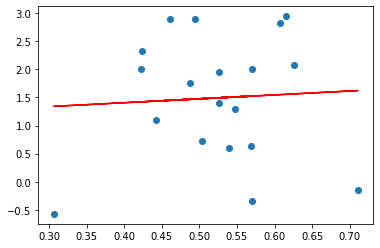

In [ ]:
outcome = df.groupby('subject').mean('CONTRA-IPSI').reset_index()

outcome['dprime'] = dPrime

df['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
mean = df.groupby('subject').mean('CONTRA-IPSI').reset_index()

outcome['CONTRA-IPSI'] = mean['CONTRA-IPSI']
#outcome = outcome.drop(15)
print(outcome['CONTRA-IPSI'])
Y = outcome['dprime'].values.reshape(-1, 1)  # values converts it into a numpy array
X = outcome['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
print(linear_regressor.coef_)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
"""
dividere i trial (5) e calcolare il dprime e cercare come varia durante il tempo e alla performance
rispetto ai gruppi (strategia utilizzata)
modello per vedere come il trial precedente influenza quello successivo
varianza nella differza tra contra e ipsi e come correla con dprime (varianza bassa migliori performance?)
alfa rispetto correttezza di trial e per to-low performers
maggiore differenza tra corretto ed errore  in contra -> minore dprime
tempo di risposta risposte corrette
numeri

fare powerpoint

In [ ]:
#dividing the top from the low performers
import statistics

median = statistics.median(outcome['dprime'])
print(median)

lowperf = outcome[outcome['dprime'] < median]
highperf = outcome[outcome['dprime'] >= median]

print(highperf)
tp = [1,4,5,6,7,10,11,16,18,19] #top performers d'
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' neutral2

top = df[df['subject'].isin(tp)]
low = df[~df['subject'].isin(tp)]

# differenza assoluta contra-ipsi dei top e low performer rispetto ai trial
# senza fare la media degli individui rispetto al trial
dfsubIAFtop = top
dfsubIAFlow = low
dfsubIAFtop['CONTRA-IPSI'] = abs(top['IAF_CONTRA'].sub(top['IAF_IPSI']))
dfsubIAFlow['CONTRA-IPSI'] = abs(low['IAF_CONTRA'].sub(low['IAF_IPSI']))
sub = pd.DataFrame(dfsubIAFtop.groupby('subject'))
sub['dprime'] = dPrime
dfsubIAFlow['dprime'] = dPrime
print(dfsubIAFlow)

X = sub['dprime'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = sub['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = dfsubIAFlow['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfsubIAFlow['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

1.7635940206135772
    subject  trial  stimulus      resp   outcome  IAF_CONTRA   IAF_IPSI  side  \
0         1  240.5       2.5  0.416667  0.866667    9.667335   9.643502   1.0   
1         2  240.5       2.5  0.437500  0.908333    9.062242   9.056990   1.0   
4         5  240.5       2.5  0.316667  0.775000    9.637455   9.621943   1.0   
5         6  240.5       2.5  0.354167  0.845833   10.708581  10.746046   1.0   
6         7  240.5       2.5  0.270833  0.762500    9.911700   9.930037   1.0   
7         8  240.5       2.5  0.147917  0.643750    9.965679   9.967901   1.0   
10       11  240.5       2.5  0.152083  0.647917   10.291091  10.301149   2.0   
11       12  240.5       2.5  0.481250  0.939583   10.839954  10.845037   2.0   
16       17  240.5       2.5  0.406250  0.856250   10.598865  10.609959   2.0   
18       19  240.5       2.5  0.464583  0.902083   10.132845  10.127125   2.0   

    confidence   resp_time    conf_time    dprime  CONTRA-IPSI  
0     3.122917  269.6062

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

KeyError: ignored

In [ ]:
sub = dfsubIAFtop.groupby('subject').mean()

In [ ]:
#analisi sulle differenze tra top e low performers
import statistics

outcome['dprime'] = dPrime
median = statistics.median(outcome['dprime'])
print(median)

lowperf = outcome[outcome['dprime'] < median]
highperf = outcome[outcome['dprime'] >= median]

print(highperf)

tpoutcome = [1,2,3,4,5,6,12,17,19] #subject 10 contains the median
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' neutral2
#tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)
df['top_low'] = 0
df.loc[df.subject.isin(tpoutcome), 'top_low'] = 1
top = df[df['top_low'] == 1]
low = df[df['top_low'] == 0]

print(np.mean(top['IAF_IPSI']))
print(np.mean(top['IAF_CONTRA']))
print(np.std(top['IAF_IPSI']))
print(np.std(top['IAF_CONTRA']))
print(np.mean(low['IAF_IPSI']))
print(np.mean(low['IAF_CONTRA']))
print(np.std(low['IAF_IPSI']))
print(np.std(low['IAF_CONTRA']))

sns.pairplot(df, hue='top_low', height=3, vars=['IAF_IPSI', 'IAF_CONTRA', 'trial']);
#sns.pairplot(df, hue='top_low', height=3, vars=['outcome', 'confidence', 'IAF_IPSI', 'IAF_CONTRA', 'resp_time', 'conf_time', 'trial']);

In [ ]:
X = top['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = top['IAF_CONTRA'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
#andamento generale rispetto ai trial

#sns.pairplot(uno, hue='trial', height=6, vars=['IAF_CONTRA', 'IAF_IPSI']);
#df.plot(kind='scatter', x='trial', y='IAF_CONTRA')
#df.plot(kind='scatter', x='trial', y='IAF_IPSI')
X = df['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df['IAF_CONTRA'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = df['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df['IAF_IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
#andamento alfa dei trial miss

single = df[df['subject'] == 1]

X = nomatch['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = nomatch['IAF_CONTRA'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

#andamento alfa di un soggetto rispetto ai trial
single = df[df['subject'] == 1]

X = nomatch['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = nomatch['IAF_IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
#differenza assoluta di alfa nei trial catch e miss
matchsub = match
nomatchsub = nomatch
matchsub['CONTRA-IPSI'] = abs(match['IAF_CONTRA'].sub(match['IAF_IPSI']))
nomatchsub['CONTRA-IPSI'] = abs(nomatch['IAF_CONTRA'].sub(nomatch['IAF_IPSI']))

single = df[df['subject'] == 1]

X = matchsub['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = matchsub['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

X = nomatchsub['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = nomatchsub['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
#differenza alfa di un soggetto (top o low perf) rispetto ai trial

tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral1)
singlesub = df[df['subject'] == 14]
singlesub['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
singlesub1 = singlesub[singlesub['outcome']==0]

X = singlesub['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = singlesub['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red', scaley=False)
plt.show()


In [ ]:
#differenza assoluta alfa nel tempo dei top e low performers
## facendo la media degli individui rispetto al trial
##
##
##
##
import statistics

outcome = df.groupby('subject').mean('outcome').reset_index()

median = statistics.median(outcome['outcome'])
print(median)
lowperf = outcome[outcome['outcome'] <= median]
highperf = outcome[outcome['outcome'] > median]

print(highperf)


tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral1)
#tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)

tpoutcome = [1,2,3,4,5,6,12,17,19] #top performers w/r to outcome
df['top_low'] = 0
df.loc[df.subject.isin(tp), 'top_low'] = 1

topdiff = df[df['top_low'] == 1]
#topdiff = topdiff.drop((topdiff[topdiff.confidence<1].index)) #outliers
#topdiff = topdiff.drop((topdiff[topdiff.confidence>4].index)) #outliers

topdiff['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
topdiff = topdiff.groupby('trial').mean('CONTRA-IPSI').reset_index() #media individui rispetto al trial

X = topdiff['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = topdiff['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])




lowdiff = df[df['top_low'] == 0]
lowdiff['CONTRA-IPSI'] = abs(df['IAF_CONTRA'].sub(df['IAF_IPSI']))
lowdiff = lowdiff.groupby('trial').mean('CONTRA-IPSI').reset_index()

X = lowdiff['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = lowdiff['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])



#print(topdiff)
#print(lowdiff)

In [ ]:
#apprendimento del task generale
single = df[df['subject'] == 1]

X = df['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df['outcome'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [ ]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

#**2.**

  Since the data contain nulls, eliminate the rows with nulls

In [ ]:
%matplotlib inline
import seaborn as sns
#sns.pairplot(sx, hue='outcome', height=3, vars=['IAF_IPSI', 'IAF_CONTRA']);
#sns.pairplot(dx, hue='outcome', height=3, vars=['IAF_IPSI', 'IAF_CONTRA']);
#sns.pairplot(df, hue='outcome', height=3, vars=['IAF_IPSI', 'IAF_CONTRA']);

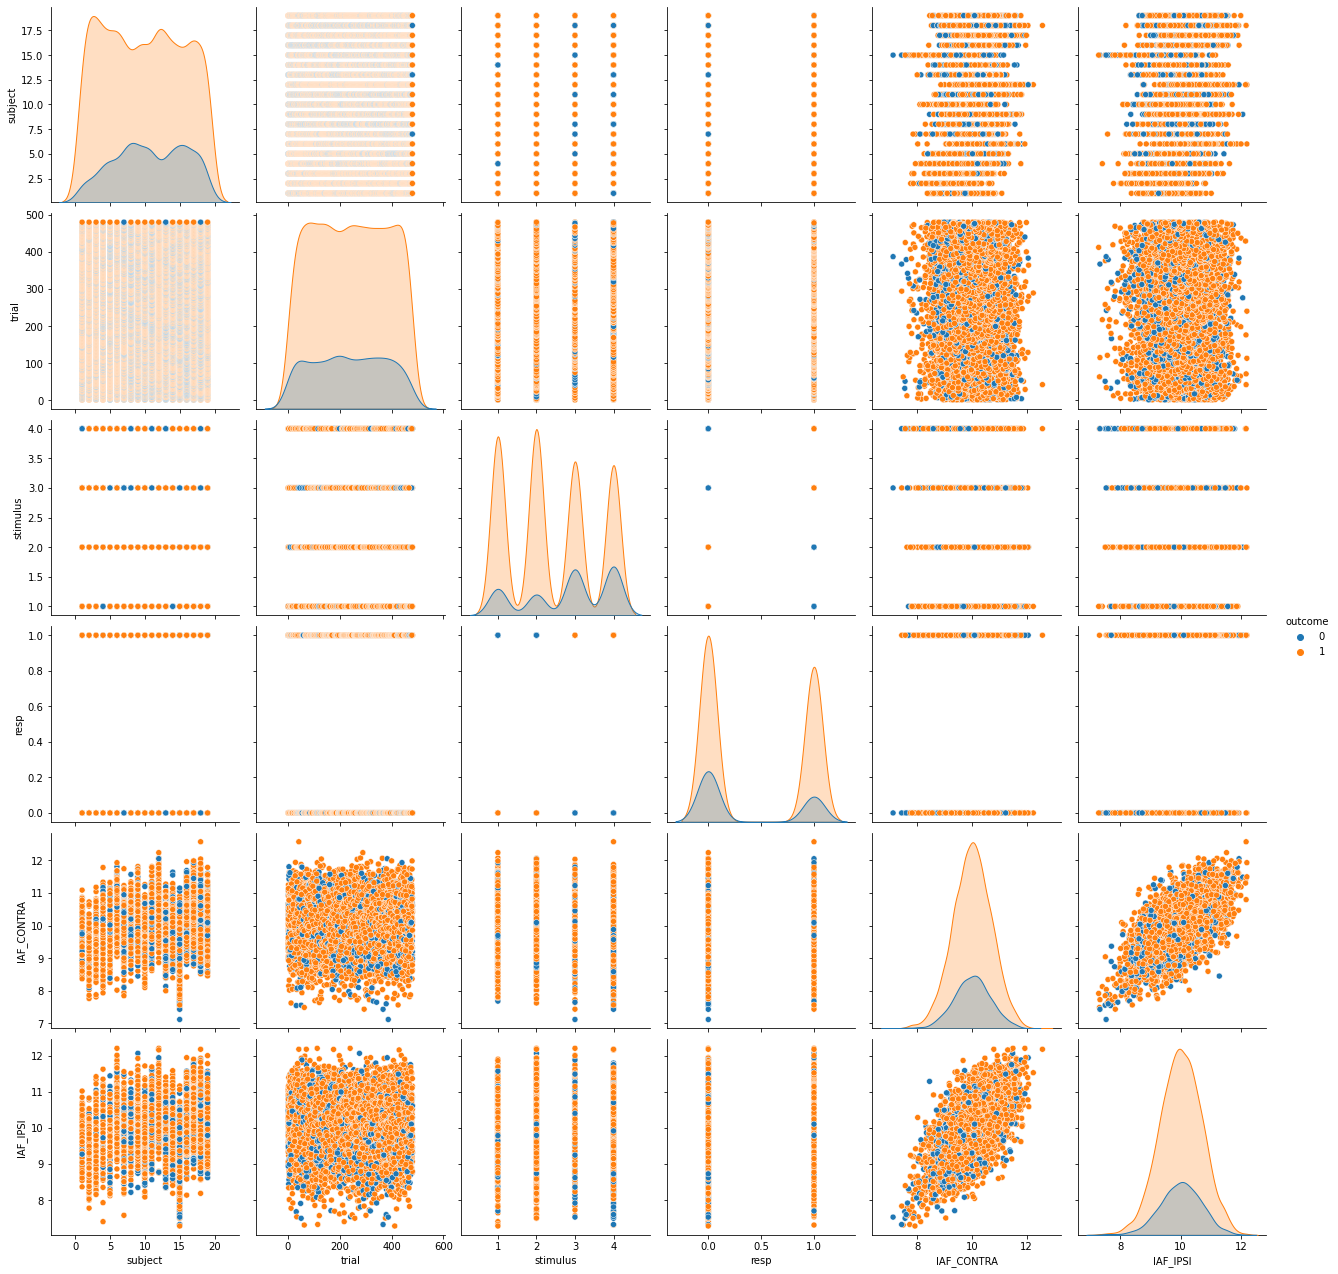

In [ ]:
sns.pairplot(df, hue='outcome', height=3)#, vars=['IAF_IPSI', 'IAF_CONTRA']);

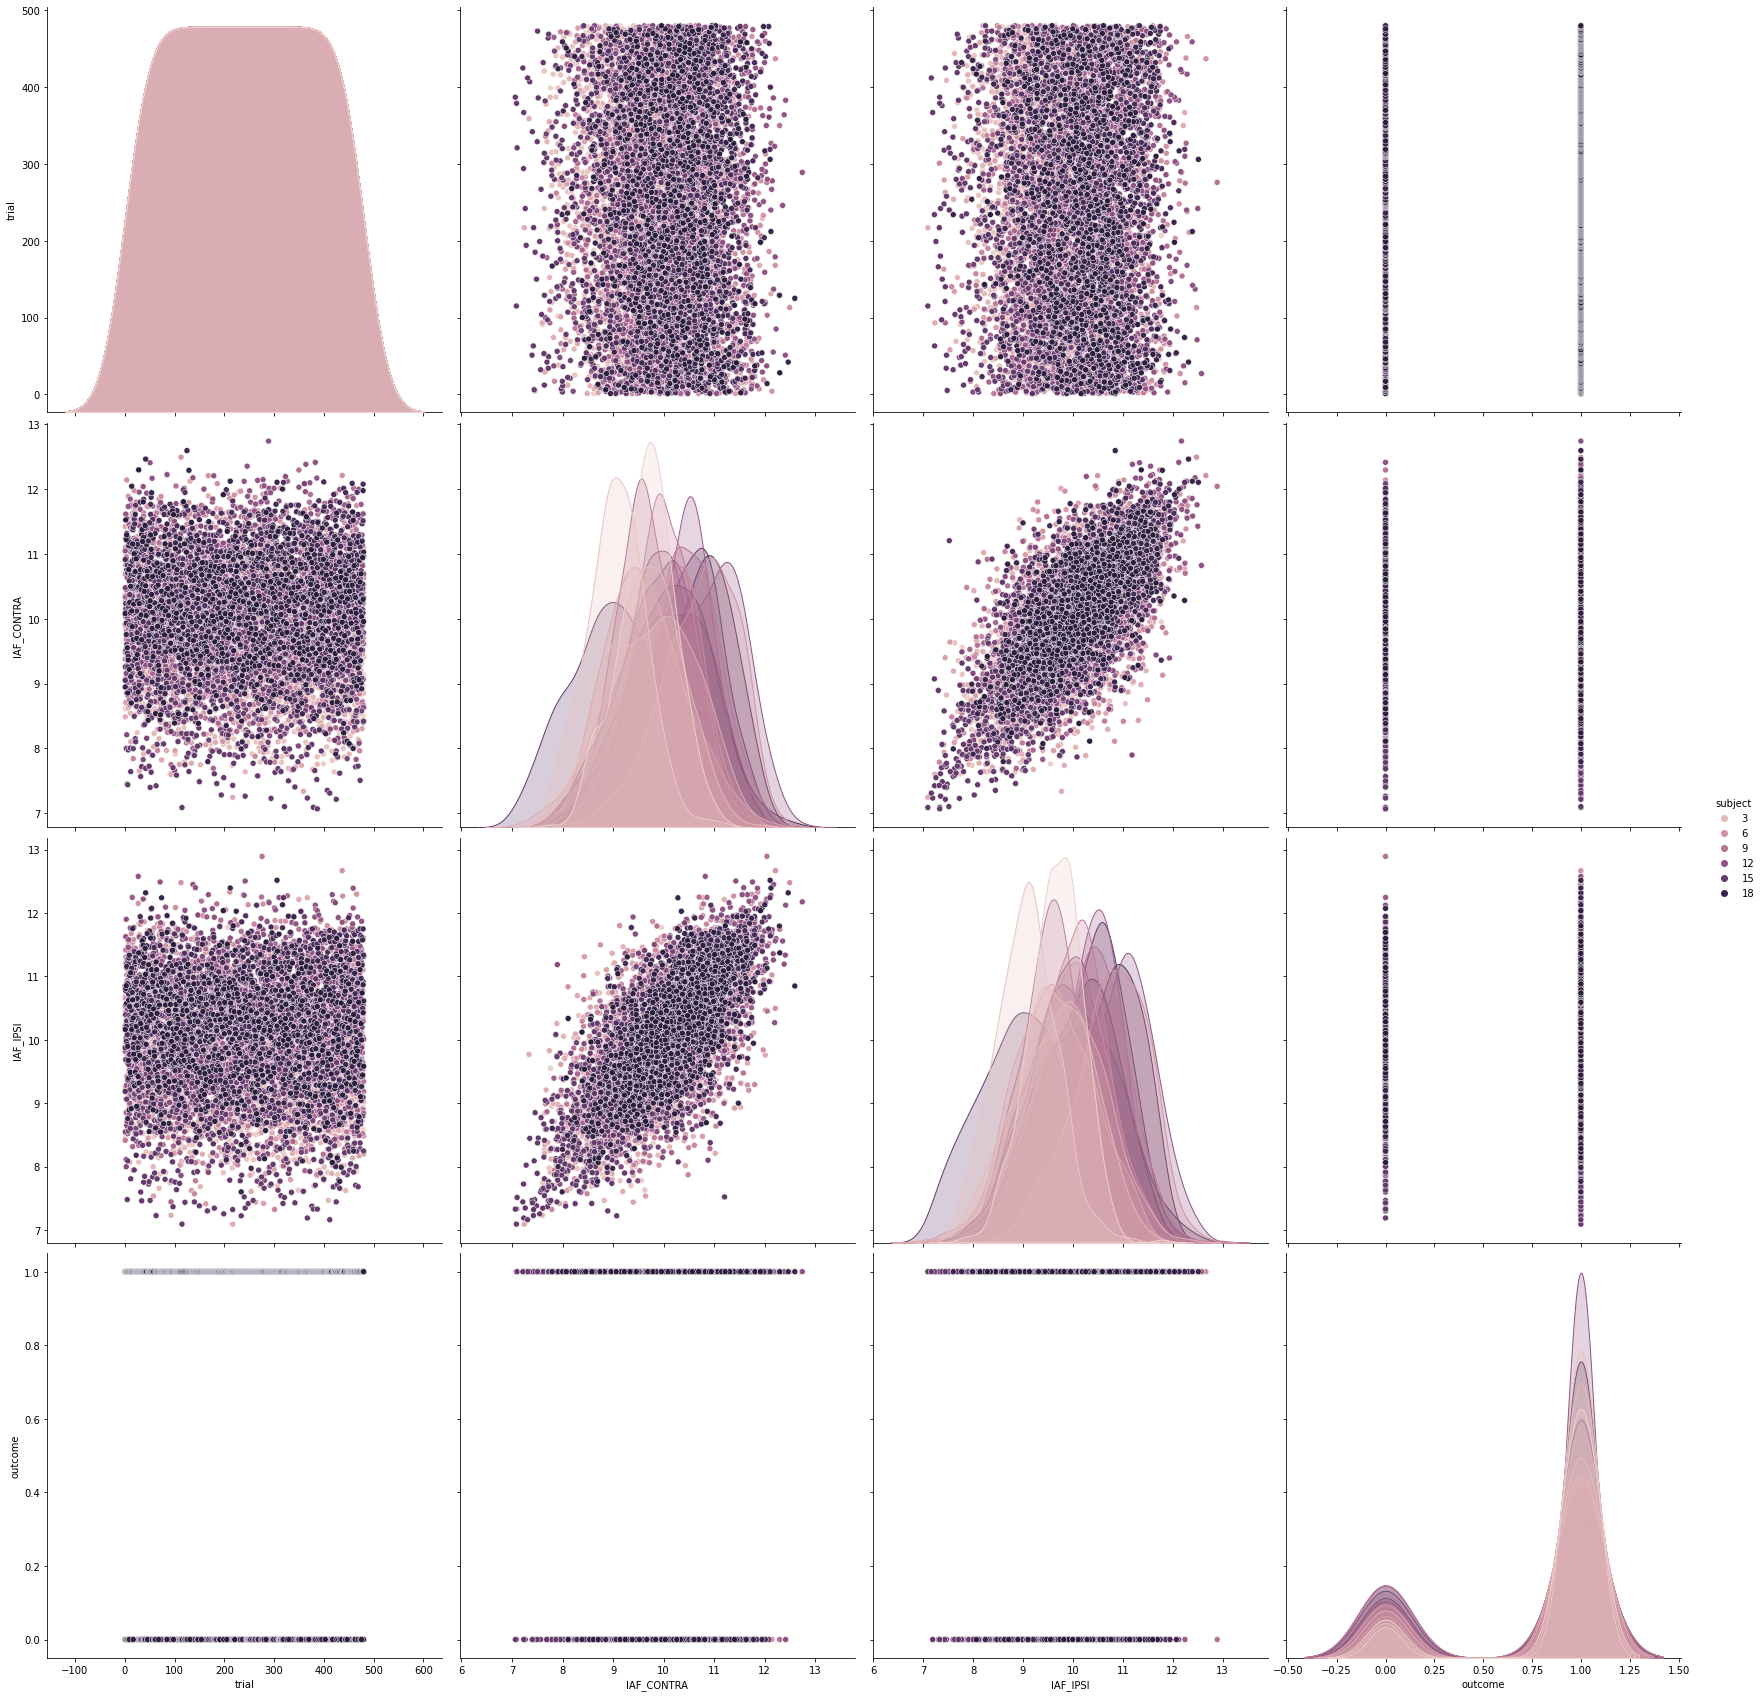

In [ ]:
#sns.pairplot(df, hue='IAF_CONTRA', height=6, vars=['trial', 'IAF_IPSI']);
sns.pairplot(df, hue='subject', height=6, vars=['trial', 'IAF_CONTRA', 'IAF_IPSI', 'outcome']);

In [ ]:
match.head()


subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI
0        1      1         2     0        1    8.980815  10.135556
1        1      2         1     0        1   10.089419   9.641815
3        1      4         2     0        1   10.251888  10.244406
4        1      5         4     1        1   10.032839   9.583125
5        1      6         2     0        1    9.646755   9.678465

In [ ]:
match = match.drop(match[match.confidence==5].index)
match = match.drop(match[match.confidence==0].index)

nomatch = nomatch.drop(nomatch[nomatch.confidence==5].index)
nomatch = nomatch.drop(nomatch[nomatch.confidence==0].index)

match.plot(kind='hist', y='confidence')
#plt.plot(kind='line', ='IAF_CONTRA', color='red')
plt.show()
nomatch.plot(kind='hist', y='confidence')
plt.show()


AttributeError: ignored

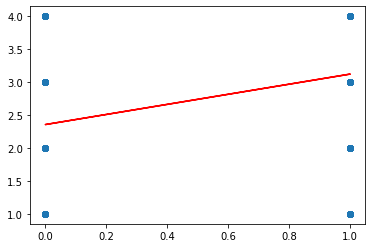

[[0.76498184]]
0.3197927734551989


In [ ]:

auto = df.drop(df[df.confidence==5].index)
auto = auto.drop(df[df.confidence==0].index)


X = auto['outcome'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = auto['confidence'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)
print(np.corrcoef(X, Y, rowvar=False)[0,1])



      subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  \
0           1      1         2     0        1    8.980815  10.135556   
1           1      2         1     0        1   10.089419   9.641815   
3           1      4         2     0        1   10.251888  10.244406   
4           1      5         4     1        1   10.032839   9.583125   
5           1      6         2     0        1    9.646755   9.678465   
...       ...    ...       ...   ...      ...         ...        ...   
9114       19    475         4     1        1   10.763357  10.541786   
9116       19    477         2     0        1   10.608406  10.802193   
9117       19    478         4     1        1   10.591348   9.498985   
9118       19    479         1     0        1   10.814284  10.283993   
9119       19    480         2     0        1    9.858579   9.957763   

      confidence  resp_time  conf_time  
0              3          0       2763  
1              4          0        351  
3           

   subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
0        1      1         2     0        1    8.618872   9.731966     1   
1        1      2         1     0        1    9.836093   9.707849     1   
2        1      3         3     0        0    9.641366  10.723487     1   
3        1      4         2     0        1   10.334433  10.203738     1   
4        1      5         4     1        1   10.343133   9.982513     1   

   confidence  resp_time  conf_time  CONTRA-IPSI  top_low  lato  
0           3          0       2763     1.113094        1     1  
1           4          0        351     0.128243        1    -1  
2           4          0        291     1.082122        1    -1  
3           4          0        276     0.130695        1     1  
4           2        885       1094     0.360620        1     1  
   subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
0        1      1         2     0        1    8.618872   9.731966     1   
1  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


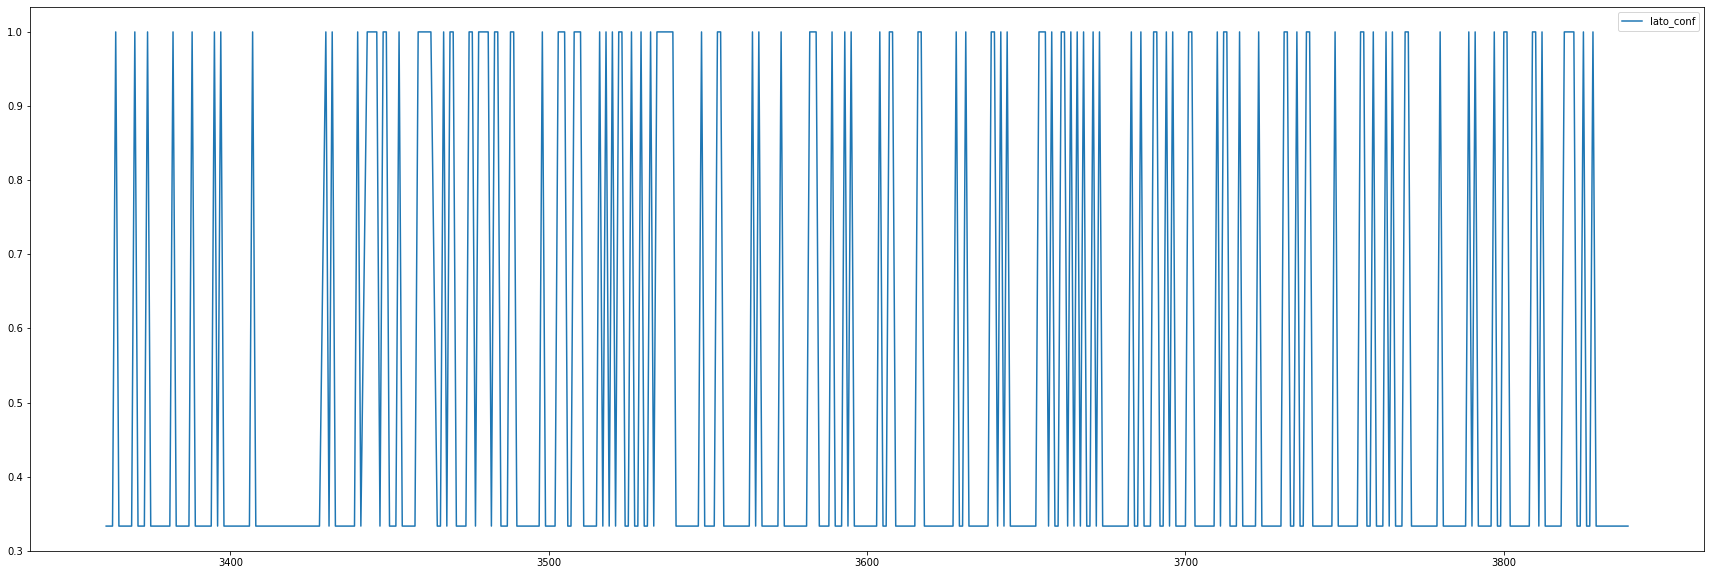

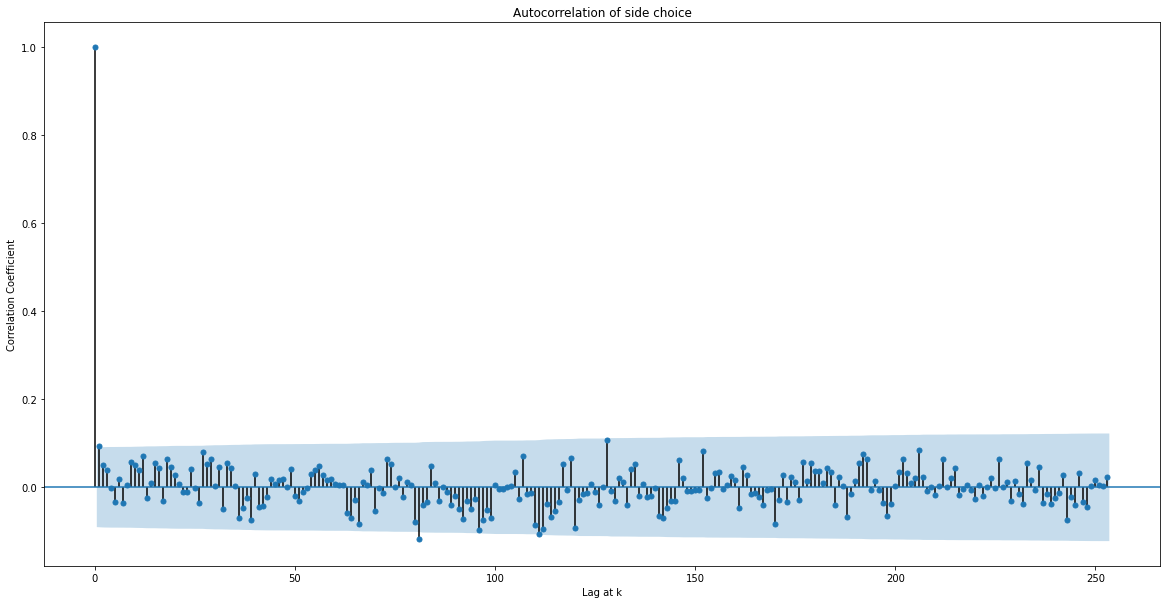

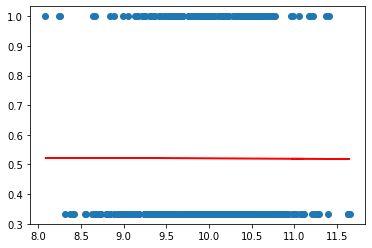

In [ ]:
#autocorrelazione lato x confidence
print(df.head())
lato = df
lato['lato'] = -1
#df[(df['stimulus'] == 1) | (df['stimulus'] == 3)] 
lato.loc[df.stimulus == 2, 'lato'] = 1
lato.loc[df.stimulus == 4, 'lato'] = 1
#print(lato.head())
tp = [1,2,5,6,7,8,11,12,17,19] #top performers d' (neutral)
#tp = [1,3,5,7,8,11,14,15,16] #top performers d' (biased2)top = df[df['subject'].isin(tp)]
low = df[~df['subject'].isin(tp)]

lato = lato.drop((lato[lato.confidence<1].index)) #outliers
lato = lato.drop((lato[lato.confidence>4].index)) #outliers
#lato = lato.drop((lato[lato.confidence==2].index)) #low conf
lato = lato.drop((lato[lato.confidence==1].index))  #low conf


lato['std_conf'] = (lato['confidence'].sub(2.5).div(1.5))
print(lato.head())
lato['lato_conf'] = lato['lato'].mul(lato['std_conf'])
lato = lato[~np.isnan(lato)]

l1 = lato[(lato['subject'] == 8 )]
l1['confidence'] = l1['confidence'].shift(1,fill_value=1)

l1 = l1.drop((l1[l1.trial==1].index)) #dropping the first row due to inexistence of previous trial and thus confidence
print(l1.head())
l1['lato_conf'] = abs(l1['lato_conf'])
bias = sum(l1['lato'] == -1)/sum(l1['lato'] == 1) # sx w/r to dx

print(bias)
l1.plot(y='lato_conf', figsize=(30,10))
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(l1["lato_conf"], lags=253)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of side choice")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

l1['CONTRA-IPSI'] = l1['IAF_CONTRA'].sub(l1['IAF_IPSI'])
X = l1['IAF_CONTRA'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = l1['lato_conf'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

     subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
0          1      1         2     0        1    8.618872   9.731966     1   
1          1      2         1     0        1    9.836093   9.707849     1   
2          1      3         3     0        0    9.641366  10.723487     1   
3          1      4         2     0        1   10.334433  10.203738     1   
4          1      5         4     1        1   10.343133   9.982513     1   
..       ...    ...       ...   ...      ...         ...        ...   ...   
475        1    476         3     1        1    9.434041  10.354319     1   
476        1    477         1     0        1    9.609150  10.602948     1   
477        1    478         4     0        0    9.400757   8.985253     1   
478        1    479         1     0        1    8.506265   8.582002     1   
479        1    480         1     0        1    9.140578   9.436410     1   

     confidence  resp_time  conf_time  CONTRA-IPSI  top_low  
0            

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'res = seasonal_decompose(single[\'IAF_CONTRA\'], model = "additive")\n\nfig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))\nres.trend.plot(ax=ax1,ylabel = "trend")\nres.resid.plot(ax=ax2,ylabel = "seasoanlity")\nres.seasonal.plot(ax=ax3,ylabel = "residual")\nplt.show()'

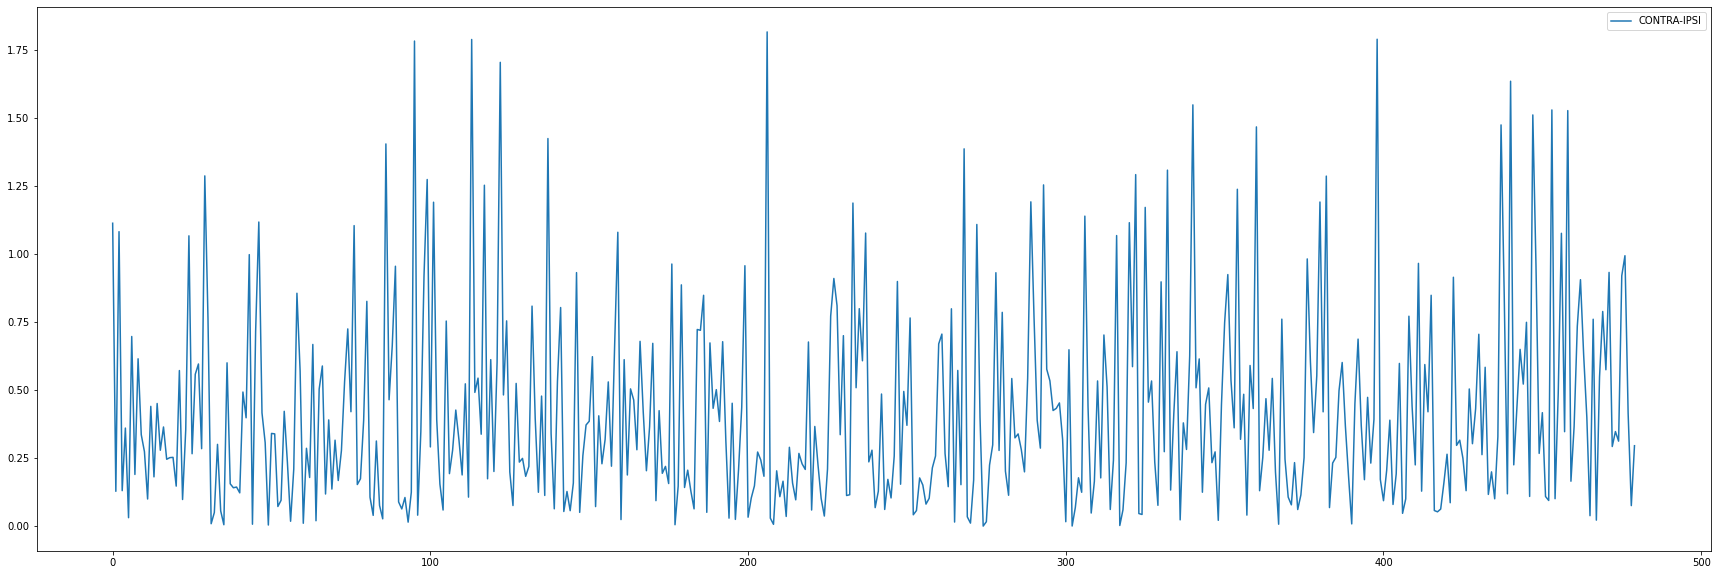

In [ ]:
#alpha and diff along trials
single=df[(df['subject'] == 1 )]
#single['CONTRA-IPSI'] = single['IAF_CONTRA'].sub(single['IAF_IPSI'])
print(single)
#df.plot(y='IAF_IPSI', figsize=(30, 10))
#single.plot(y='IAF_CONTRA', figsize=(30, 10))
single.plot(y='CONTRA-IPSI', figsize=(30, 10))

from statsmodels.tsa.seasonal import seasonal_decompose

"""res = seasonal_decompose(single['IAF_CONTRA'], model = "additive")

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()"""


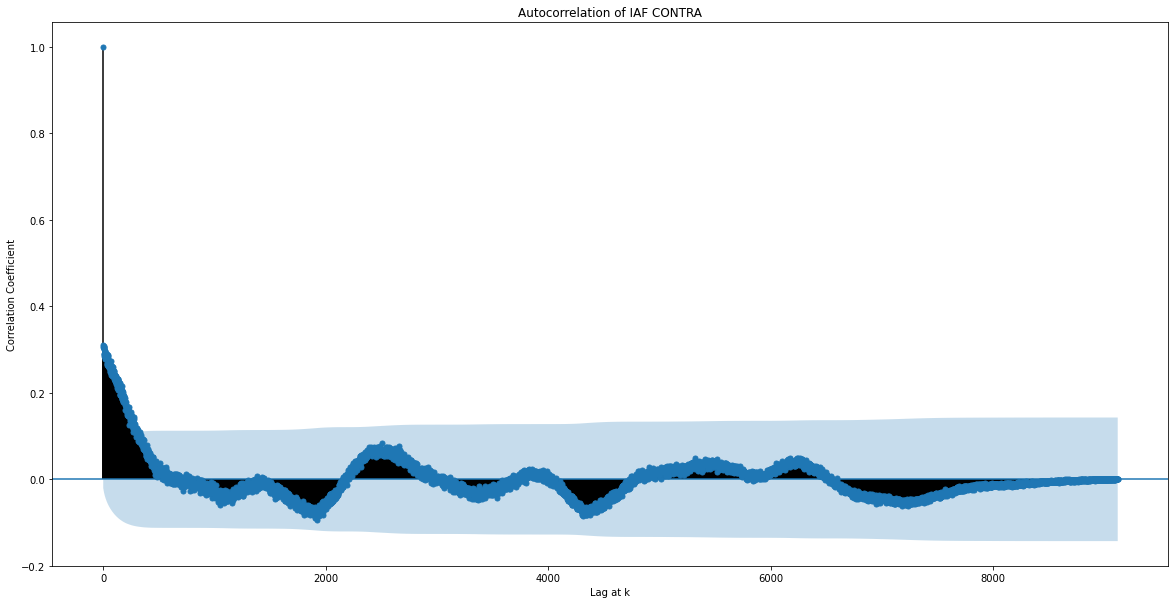

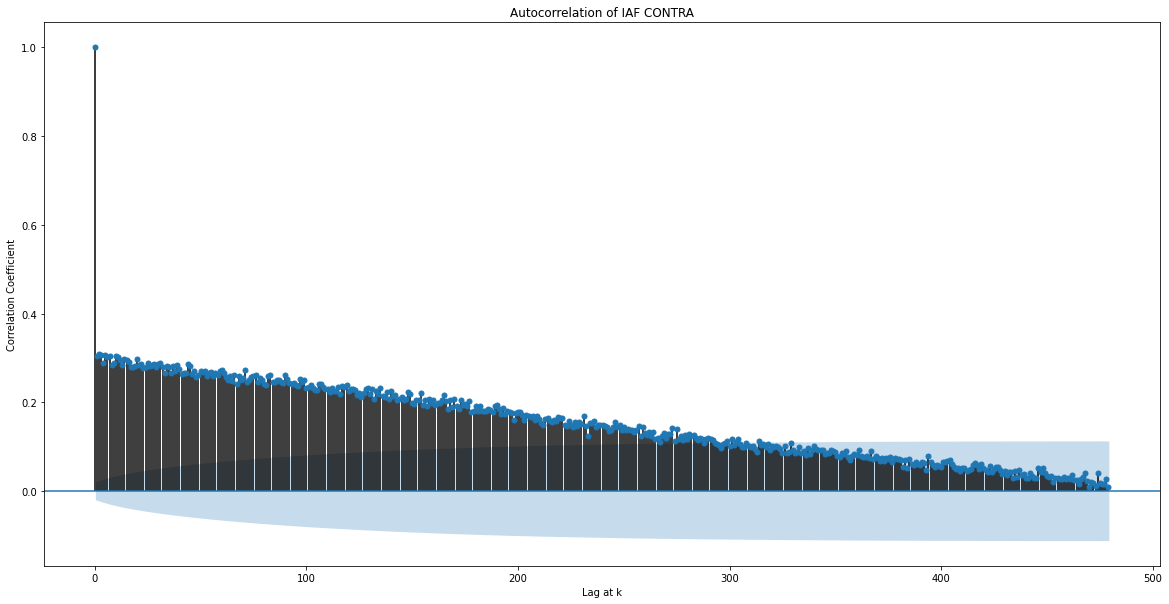

In [ ]:
#autocorrelazione generale alfa contralaterale
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(df["IAF_CONTRA"], lags=9119)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(df["IAF_CONTRA"], lags=479)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

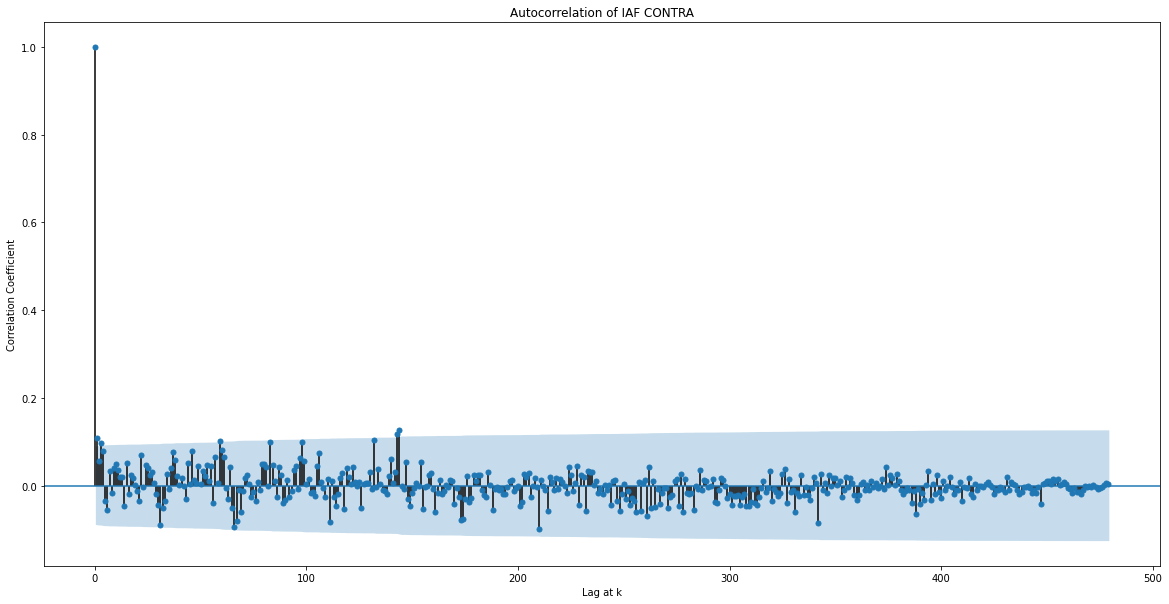

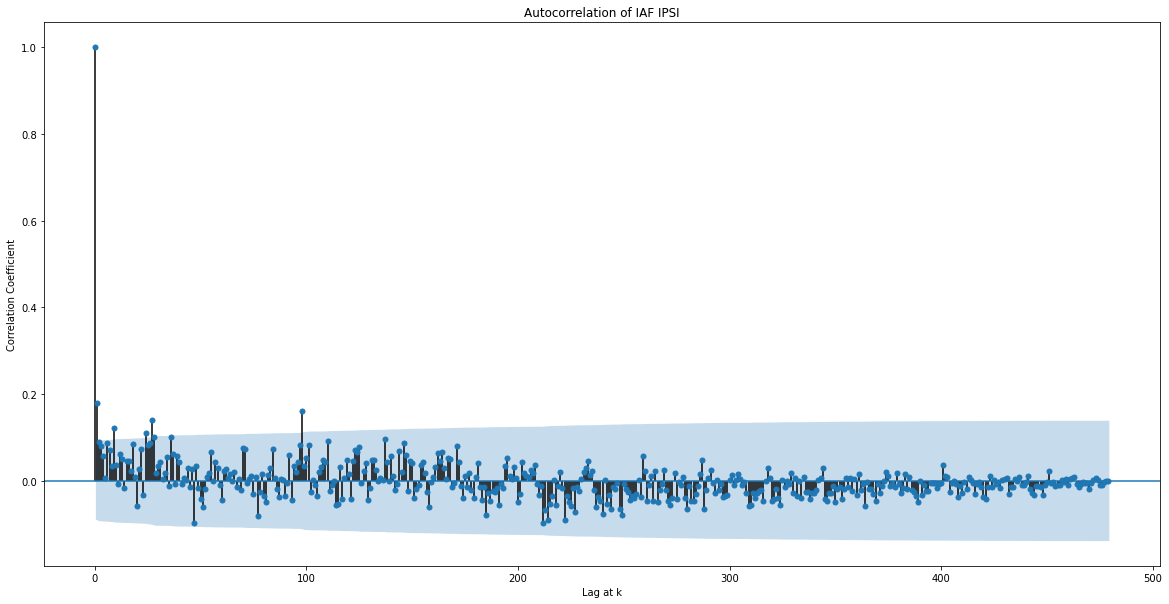

In [ ]:
#autocorrelazione di alfa del singolo rispetto ai trial

single=df[(df['subject'] == 1)]


from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(single["IAF_CONTRA"], lags=479)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

fig = tsaplots.plot_acf(single["IAF_IPSI"], lags=479)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF IPSI")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


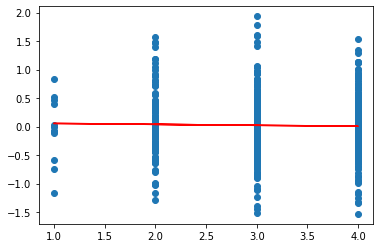

'"\nsingle[\'std_conf\'] = (single[\'confidence\'].sub(2.5).div(1.5))\nprint(single.head())\nsingle = single[~np.isnan(single)]\nsingle[\'contra_conf\'] = single[\'IAF_CONTRA\'].mul(single[\'confidence\'])\n\nsingle.plot(y=\'contra_conf\', figsize=(30, 10))\n\nfrom statsmodels.graphics import tsaplots\n\nfig = tsaplots.plot_acf(single["contra_conf"], lags=314)\nfig.set_size_inches(20,10)\nplt.title("Autocorrelation of IAF CONTRA weighted")\nplt.xlabel("Lag at k")\nplt.ylabel("Correlation Coefficient")\nplt.show();\n\nsingle[\'CONTRA-IPSI\'] = single[\'IAF_CONTRA\'].sub(single[\'IAF_IPSI\'])\nsingle[\'diff_conf\'] = single[\'CONTRA-IPSI\'].mul(single[\'confidence\'])\nsingle.plot(y=\'diff_conf\', figsize=(30, 10))\n\nfig = tsaplots.plot_acf(single["diff_conf"], lags=314)\nfig.set_size_inches(20,10)\nplt.title("Autocorrelation of alpha difference weighted")\nplt.xlabel("Lag at k")\nplt.ylabel("Correlation Coefficient")\nplt.show();'

In [ ]:
#alpha contra weighted through trials
single = df[df['subject'] == 10]
single['confidence'] = single['confidence'].shift(1,fill_value=1)
single = single.drop((single[single.trial==1].index))

single = single.drop((single[single.confidence<1].index)) #outliers
single = single.drop((single[single.confidence>4].index)) #outliers

#single = single.drop((single[single.confidence==1].index)) #low conf
#single = single.drop((single[single.confidence==2].index)) #low conf
single['CONTRA-IPSI'] = single['IAF_CONTRA'].sub(single['IAF_IPSI'])
X = single['confidence'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = single['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
""""
single['std_conf'] = (single['confidence'].sub(2.5).div(1.5))
print(single.head())
single = single[~np.isnan(single)]
single['contra_conf'] = single['IAF_CONTRA'].mul(single['confidence'])

single.plot(y='contra_conf', figsize=(30, 10))

from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(single["contra_conf"], lags=314)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

single['CONTRA-IPSI'] = single['IAF_CONTRA'].sub(single['IAF_IPSI'])
single['diff_conf'] = single['CONTRA-IPSI'].mul(single['confidence'])
single.plot(y='diff_conf', figsize=(30, 10))

fig = tsaplots.plot_acf(single["diff_conf"], lags=314)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of alpha difference weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


      subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
3361        8      2         3     0        0   11.106647  11.416264     1   
3362        8      3         2     0        1    9.681975   9.888821     1   
3363        8      4         2     0        1    9.816518   9.944445     1   
3364        8      5         2     0        1   10.376760  10.166530     1   
3365        8      6         3     0        0   10.275669  10.483613     1   

      confidence  resp_time  conf_time  CONTRA-IPSI  top_low  lato  std_conf  
3361           3          0        720     0.309617        1    -1  1.732051  
3362           3          0        514     0.206846        1     1  1.732051  
3363           3          0        416     0.127927        1     1  1.732051  
3364           3          0        372     0.210230        1     1  1.732051  
3365           4          0        430     0.207944        1    -1  2.000000  


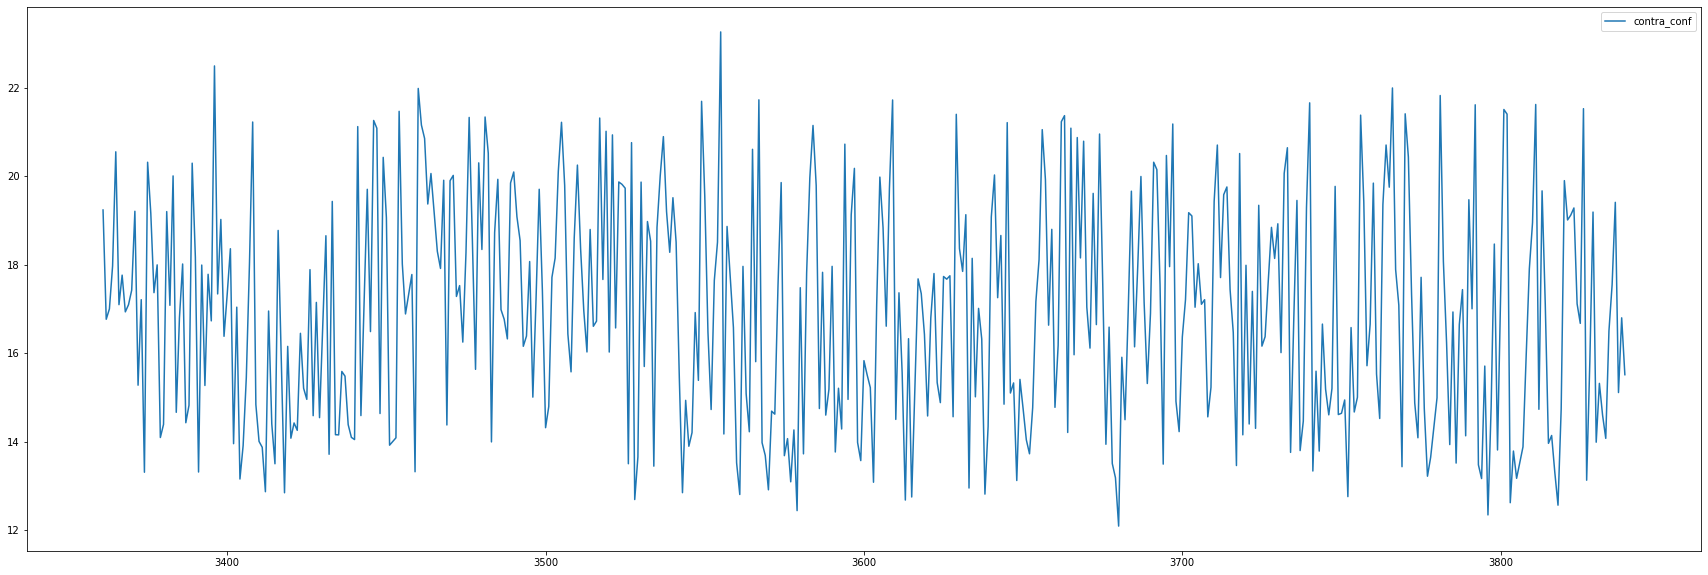

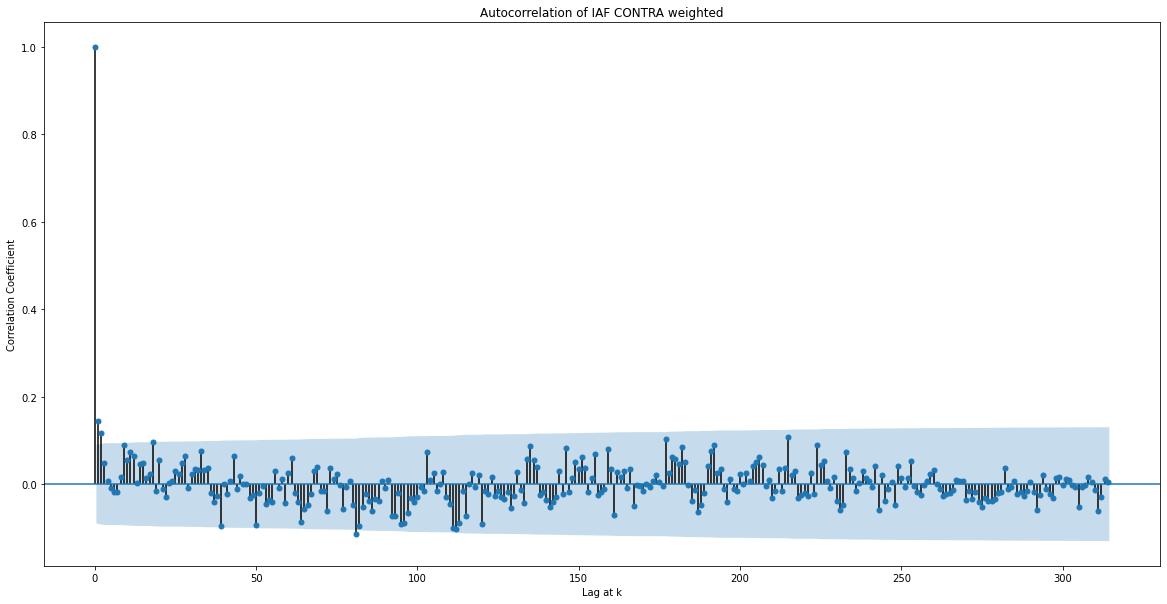

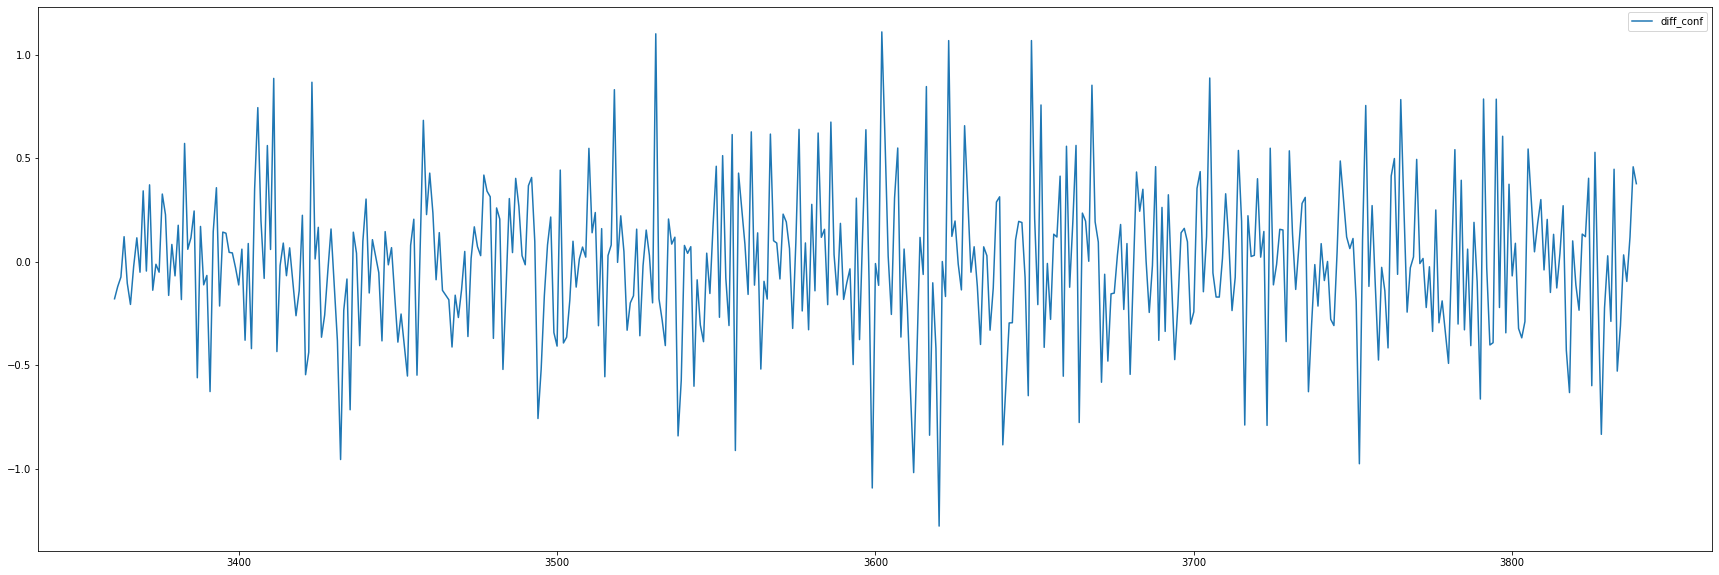

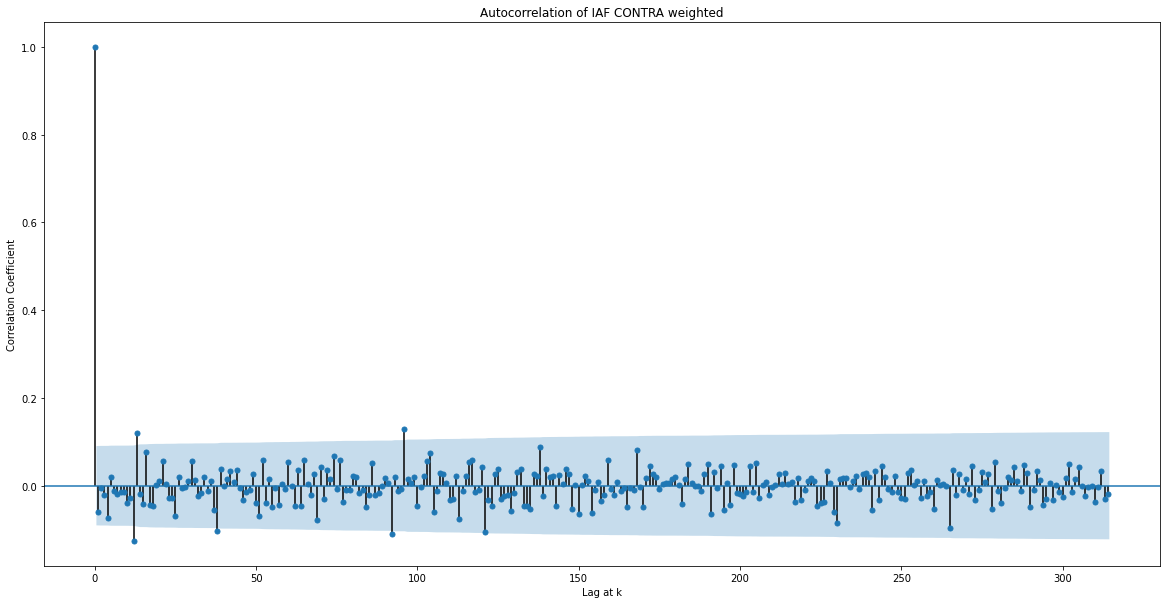

In [ ]:
#alpha contra and difference and autocorrelation
good = df[df['subject'] == 8]
good['confidence'] = good['confidence'].shift(1,fill_value=1)
good = good.drop((good[good.confidence==1].index))
#good = good.drop((good[good.confidence==2].index))
good = good.drop((good[good.confidence<1].index))
good = good.drop((good[good.confidence>4].index)) 

good = good[~np.isnan(good)]


good['std_conf'] = np.sqrt(good['confidence'])#.sub(2.5).div(1.5))
print(good.head())
good['contra_conf'] = good['IAF_CONTRA'].mul(good['std_conf'])
good = good[~np.isnan(good)]

#contra
good.plot(y='contra_conf', figsize=(30, 10))

from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(good["contra_conf"], lags=314)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

#difference
good['CONTRA-IPSI'] = good['IAF_CONTRA'].sub(good['IAF_IPSI'])
good['diff_conf'] = good['CONTRA-IPSI'].div(good['std_conf'])
good = good[~np.isnan(good)]

good.plot(y='diff_conf', figsize=(30, 10))

fig = tsaplots.plot_acf(good["diff_conf"], lags=314)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


      subject  trial  stimulus  resp  outcome  IAF_CONTRA   IAF_IPSI  side  \
4801       11      2         2     0        1   10.028554  10.410430     2   
4802       11      3         4     0        0   10.941876   9.280430     2   
4803       11      4         3     0        0    9.150630   8.676298     2   
4804       11      5         1     0        1    9.397901  10.105752     2   
4805       11      6         1     0        1    9.020381   9.715777     2   

      confidence  resp_time  conf_time  CONTRA-IPSI  top_low  lato  std_conf  
4801           4          0       2355     0.381876        1     1     0.825  
4802           3          0       1770     1.661447        1     1     0.950  
4803           2          0       1210     0.474333        1    -1     1.075  
4804           4          0       1157     0.707851        1    -1     0.825  
4805           3          0       1739     0.695396        1    -1     0.950  


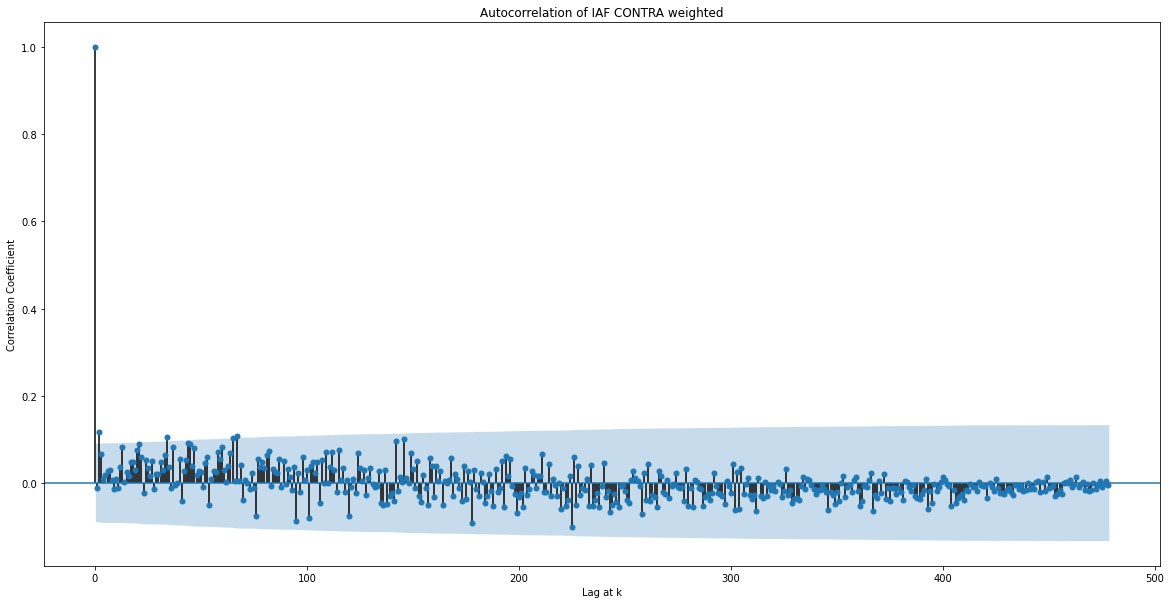

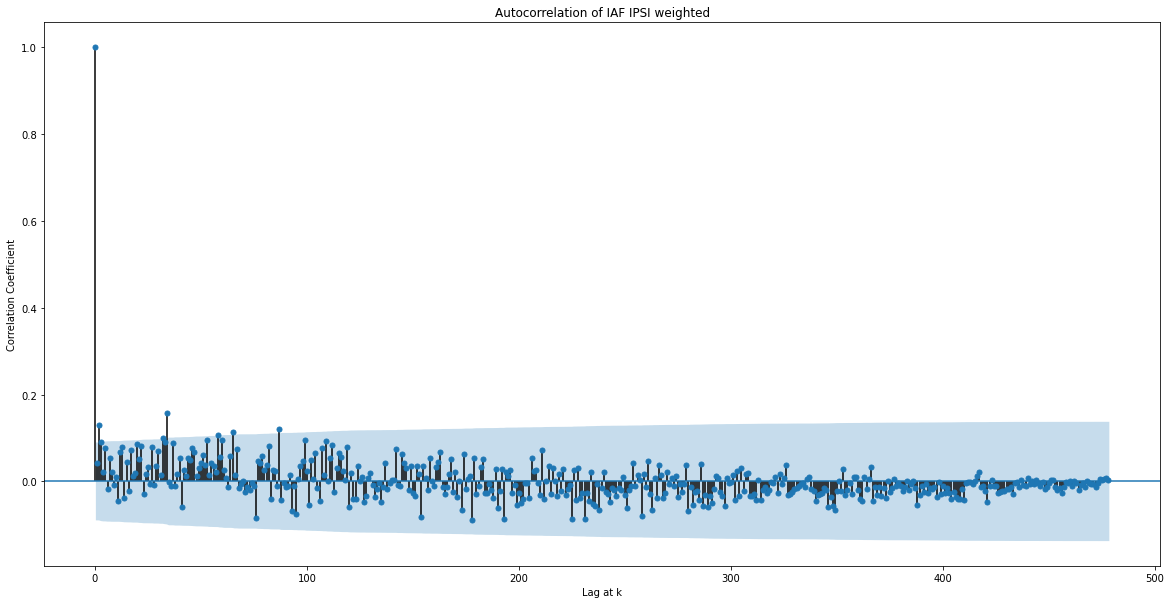

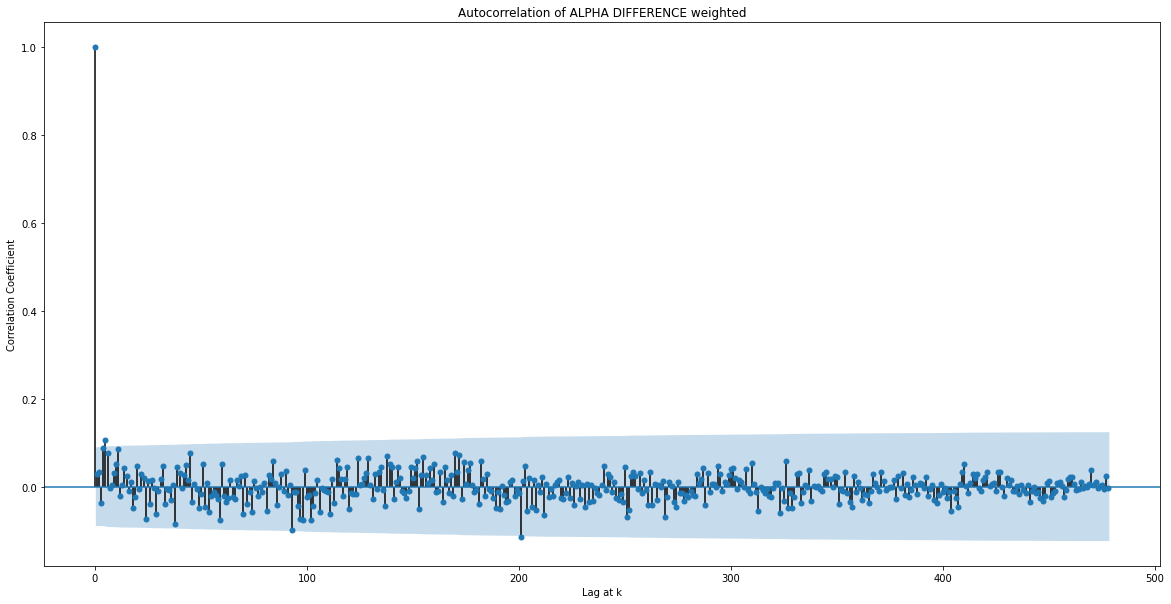

In [ ]:
#autocorrelazione di alfa del singolo pesato per la confidenza
###################
###################
from statsmodels.graphics import tsaplots

single = df[df['subject'] == 11]
single['confidence'] = single['confidence'].shift(1,fill_value=1)
single = single.drop((single[single.trial==1].index))

single['std_conf'] = (single['confidence'].sub(10.6).div(-8))
print(single.head())
single = single[~np.isnan(single)]
single['contra_conf'] = single['IAF_CONTRA'].mul(single['std_conf'])

fig = tsaplots.plot_acf(single["contra_conf"], lags=478)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF CONTRA weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

single['ipsi_conf'] = single['IAF_IPSI'].mul(single['std_conf'])

fig = tsaplots.plot_acf(single["ipsi_conf"], lags=478)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of IAF IPSI weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

single['CONTRA-IPSI'] = abs(single['IAF_CONTRA'].sub(single['IAF_IPSI']))
single['diff_conf'] = single['CONTRA-IPSI'].mul(single['std_conf'])

fig = tsaplots.plot_acf(single["diff_conf"], lags=478)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of ALPHA DIFFERENCE weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

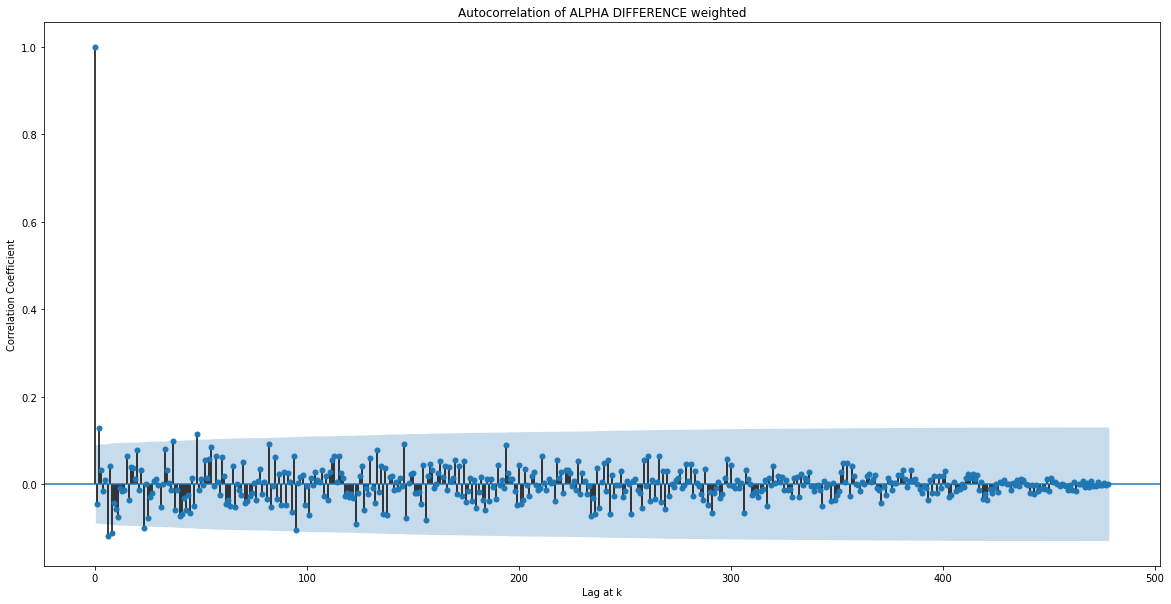

In [ ]:
#autocorrelation of all partecipants (alpha difference)
auto = single
auto['confidence'] = auto['confidence'].shift(fill_value=1)

auto['CONTRA-IPSI'] = abs(auto['IAF_CONTRA'].sub(auto['IAF_IPSI']))
auto['std_conf'] = (auto['confidence'].sub(2.5)).mul(1.5)
auto['contra_conf'] = auto['IAF_CONTRA'].div(auto['std_conf'])

fig = tsaplots.plot_acf(auto["contra_conf"], lags=478)
fig.set_size_inches(20,10)
plt.title("Autocorrelation of ALPHA DIFFERENCE weighted")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

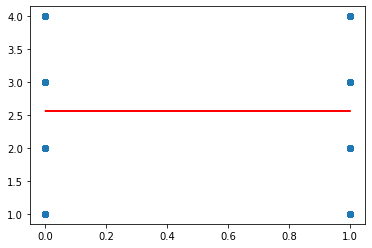

[[-0.00083985]]


In [ ]:
#relazione tra confidence e differenza alpha

X = auto['outcome'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = auto['confidence'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print(linear_regressor.coef_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


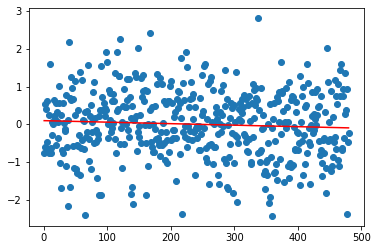

In [ ]:
#andamento generale della differenza tra alfa contra e ipsi rispetto ai trial del soggetto x
single=df[(df['subject'] == 4)]

dfsubIAF = single
dfsubIAF['CONTRA-IPSI'] = dfsubIAF['IAF_CONTRA'].sub(dfsubIAF['IAF_IPSI'])
dfsubIAF.head()
X = dfsubIAF['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfsubIAF['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


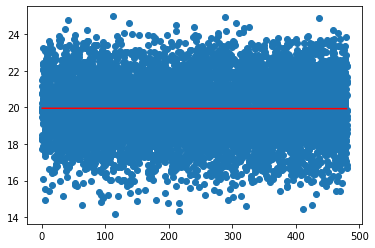

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


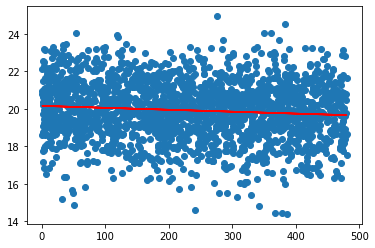

In [ ]:
dfsubIAF = match
dfsubIAF['CONTRA-IPSI'] = dfsubIAF['IAF_CONTRA'].add(dfsubIAF['IAF_IPSI'])
dfsubIAF.head()
X = dfsubIAF['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfsubIAF['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

dfsubIAF = nomatch
dfsubIAF['CONTRA-IPSI'] = dfsubIAF['IAF_CONTRA'].add(dfsubIAF['IAF_IPSI'])
dfsubIAF.head()
X = dfsubIAF['trial'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfsubIAF['CONTRA-IPSI'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()


#**3.**

Since one of the predicting attributes is ordinal, it must be converted into numeric, you can use the OrdinalEncoder

In [ ]:
transf_dtype = np.int32

ordinal_features = [2]

ordinal_transformer = OrdinalEncoder(dtype = transf_dtype)
preprocessor = ColumnTransformer(
    transformers = [('ord', ordinal_transformer, ordinal_features)], remainder = 'passthrough')

df_p = pd.DataFrame(preprocessor.fit_transform(df))

df_p.head()

0    1    2    3    4
0  0.0  5.0  3.6  0.2  0.0
1  0.0  5.0  3.4  0.2  0.0
2  0.0  5.4  3.7  0.2  0.0
3  0.0  4.8  3.4  0.2  0.0
4  0.0  4.3  3.0  0.1  0.0

#**4.**

Split the data into train and test

In [ ]:
X = df_p.drop(df_p.columns[-1], axis = 1)
y = df_p.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rnd_state)

#**5.**

Use two classification models of your choice (say: model 1 and model 2) execute the tasks below

I choose to use the GridSearch because the function GridSearchC` iterates a cross validation experiment to train and test a model with different combinations of paramater values. Therefore it is the best method to perform the cross validation.

In [ ]:
model_lbls = [
             'dt', 
             'nb'
            ]

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]


# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          }
}

# scores to be explored
score = 'precision'

#**6.**

Model 1: find and show the best hyperparameter setting with cross validation on the training set, optimise for the best accuracy     

My model 1 is the decision tree

In [ ]:
model1 = GridSearchCV(estimator= models.get('dt').get('estimator'), param_grid= tuned_param_dt, scoring = '%s_macro' % score);
model1.fit(X_train, y_train);

print()
print("The best hyper parameter from the grid search is: {}".format(model1.best_params_))

max_depth = model1.best_params_.get("max_depth")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr


The best hyper parameter from the grid search is: {'max_depth': 6}


#**7.**

Model 1: show the accuracy of classification and the confusion matrix on the test set
For the confusion matrix use plot_confusion_matrix normalized in order to show for each class the precision (read carefully the documentation)

In [ ]:
model1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)

ytrain_model1 = model1.fit(X_train, y_train).predict(X_test)

accuracy1 = accuracy_score(y_test, ytrain_model1)*100
print("Accuracy of model1: {:.2f}%".format(accuracy1))

Accuracy of model1: 97.30%


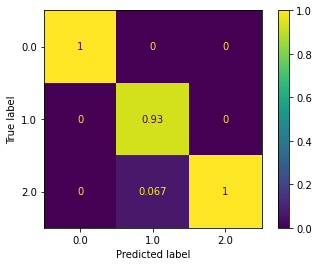

In [ ]:
plot_confusion_matrix(model1, X_test, y_test, normalize="pred")
plt.show() 

#**8.**

Model 2: find and show the best hyperparameter setting with cross validation on the training set, optimise for the best accuracy  

My model 2 is the naive bayes classifier

In [ ]:
model2 = GridSearchCV(estimator= models.get('nb').get('estimator'), param_grid= tuned_param_nb, scoring = '%s_macro' % score);
model2.fit(X_train, y_train);

print()
print("The best hyper parameter from the grid search is: {}".format(model2.best_params_))

var_smoothing = model2.best_params_.get("var_smoothing")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr


The best hyper parameter from the grid search is: {'var_smoothing': 0.1}


As we can see from the grid search the best param for the decision three is 'var_smoothing': 0.01

#**9.**

Model 2: show the accuracy of classification and the confusion matrix on the test set
For the confusion matrix use plot_confusion_matrix normalized in order to show for each class the precision (read carefully the documentation)

In [ ]:
model2 = GaussianNB(var_smoothing=var_smoothing)

ytrain_model2 = model2.fit(X_train, y_train).predict(X_test)

accuracy2 = accuracy_score(y_test, ytrain_model2)*100
print("Accuracy of model2: {:.2f}%".format(accuracy2))

Accuracy of model2: 100.00%


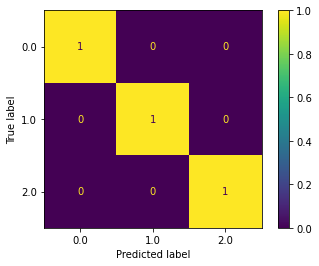

In [ ]:
plot_confusion_matrix(model2, X_test, y_test, normalize="pred")
plt.show() 